In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cinnabar.plotting import _master_plot
from cinnabar import stats

In [2]:
# load the basic edge data
cumulative_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_cumulative_data.csv")
# load our edge data with exp values
normal_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_edge_data.csv")

In [3]:
# load the rerun data
rerun_cumulative_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_cumulative_data.csv")
# load the rerun edge data with exp values
rerun_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_edge_data.csv")

In [4]:
# drop the pfkfb3 data from the default and add the rerun data
cumulative_data = cumulative_data[cumulative_data["system name"] != "pfkfb3"]
cumulative_data = pd.concat([cumulative_data, rerun_cumulative_data], ignore_index=True)
# drop the pfkfb3 data from the default and add the rerun data
normal_edge_data = normal_edge_data[(normal_edge_data["system name"] != "pfkfb3")]
normal_edge_data = pd.concat([normal_edge_data, rerun_edge_data], ignore_index=True)
normal_edge_data

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,28.411707,0.110235,27.245596,0.113900,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,32.545681,0.207117,-21.401634,0.074439,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,29.240601,0.198225,17.934588,0.088183,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,4.466974,0.022621,-3.680717,0.204893,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,3.812082,0.138050,4.873596,0.068123,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,68.239609,0.098195,5.025639,0.083096,47.049469,68.496689,0.104164,NaN,merck,pfkfb3
1195,65,29,0.704688,0,1.000000,0.155796,0.895401,0.484258,30,0,...,67.026726,0.157674,-83.240725,0.102459,29.012836,53.727703,0.160825,NaN,merck,pfkfb3
1196,29,64,0.778801,0,1.000000,0.155630,0.895401,0.462020,30,1,...,54.050873,0.165275,86.337561,0.101216,46.250511,68.017464,0.164021,NaN,merck,pfkfb3
1197,47,46,0.548812,0,1.000000,0.202290,0.735485,0.305883,27,2,...,52.765472,0.133457,-11.214751,0.046477,43.071308,66.045006,0.131496,NaN,merck,pfkfb3


In [5]:
# load the private edge and cumulative data
private_cumulative_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_cumulative_data.csv")
private_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_edge_data.csv")
private_edge_data = private_edge_data[private_edge_data["failed"] != True]
private_edge_data

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_dDG (kcal/mol),complex_repeat_1_com_drift_max,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed
0,unknown_ligand_6,unknown_ligand_9,1.000000,0,1.0,1.000000,1.000000,0.999901,21,0,...,2.231493e-10,1.496107,2.483988,0.090909,0.000000,2.839362e-10,1.771044,2.238705,0.090909,NaN
1,unknown_ligand_3,unknown_ligand_15,0.904837,0,1.0,0.046432,1.000000,0.761981,20,1,...,2.455996e-02,1.615484,2.155722,0.103056,-0.601893,2.564494e-02,1.976220,3.056871,0.103643,NaN
2,unknown_ligand_15,unknown_ligand_21,0.904837,0,1.0,0.046591,1.000000,0.762179,20,0,...,3.643987e-02,2.341021,3.475891,0.110198,1.370174,3.546106e-02,2.180326,3.084103,0.106760,NaN
3,unknown_ligand_15,unknown_ligand_5,0.904837,0,1.0,0.047457,1.000000,0.757272,20,0,...,2.883455e-02,1.911599,2.986635,0.119243,-0.866684,3.144320e-02,1.628999,2.337637,0.117861,NaN
4,unknown_ligand_21,unknown_ligand_5,0.818731,0,1.0,0.091968,1.000000,0.677922,20,1,...,4.467752e-02,1.444678,3.283127,0.121850,-1.953068,5.534813e-02,1.782087,3.081785,0.126268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,ligand11,ligand12,0.020242,0,1.0,0.205950,0.405952,0.895260,26,16,...,4.390646e-01,125.984756,126.013779,0.008125,-152.669851,6.001595e-01,111.879089,111.980225,0.002787,NaN
1428,ligand0,ligand11,0.030197,0,1.0,0.193953,0.406137,0.942570,26,9,...,4.335208e-01,118.773781,118.922112,0.012684,114.461670,2.665547e-01,120.105179,120.169167,0.012729,NaN
1429,ligand8,ligand3,0.212248,0,1.0,0.165417,0.645056,0.793032,28,7,...,3.166176e-01,122.461555,122.546555,0.017953,-21.543263,2.768983e-01,115.884491,115.910095,0.016368,NaN
1430,ligand2,ligand3,0.272532,0,1.0,0.157825,0.671910,0.831267,28,5,...,2.358288e-01,121.872475,122.149765,0.028739,100.395024,1.945049e-01,122.015831,122.021210,0.025002,NaN


In [6]:
# load the dg data
public_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_calculated_dg_data.csv")
private_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_calculated_dg_data.csv")

In [7]:
# calculate the mean ddg uncertainty for the public and private data 
public_complex_data = normal_edge_data[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
public_solvent_data = normal_edge_data[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
private_complex_data = private_edge_data[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
private_solvent_data = private_edge_data[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
public_uncertainty = (public_complex_data.std(axis=1) ** 2 + public_solvent_data.std(axis=1) **2) ** 0.5
print(public_uncertainty.mean())
private_uncertainty = (private_complex_data.std(axis=1) ** 2 + private_solvent_data.std(axis=1) **2) ** 0.5
print(private_uncertainty.mean())



0.34967104461418635
0.6333880751933342


In [8]:
# the cumulative data has each phase and repeat on a new line
# create a new csv with the DDG prediction for the edge after each ns + the error
per_ns_ddgs_neutral, per_ns_ddgs_charged = [], []
for _, row in normal_edge_data.iterrows():
    # skip the intermediates as we need to calculate the error for the edges
    if pd.isna(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "system group": row["system group"],
        "system name": row["system name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each ns
    temp_cumulative_data = cumulative_data[(cumulative_data["system group"] == row["system group"]) & (cumulative_data["system name"] == row["system name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]

    for i in range(1, total_ns + 1):
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {i} ns DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {i} ns dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    # workout where to store the row
    if total_ns == 5:
        per_ns_ddgs_neutral.append(cumulative_data_row)
    else:
        per_ns_ddgs_charged.append(cumulative_data_row)
    


In [9]:
# same again for the private data
per_ns_ddgs_neutral_private, per_ns_ddgs_charged_private = [], []
for _, row in private_edge_data.iterrows():
    # skip the intermediates as we need to calculate the error for the edges
    if pd.isna(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "partner": row["partner_id"],
        "system name": row["dataset_name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each ns
    temp_cumulative_data = private_cumulative_data[(private_cumulative_data["partner_id"] == row["partner_id"]) & (private_cumulative_data["dataset_name"] == row["dataset_name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]

    for i in range(1, total_ns + 1):
        # print(complex_data[f"Samples {i}ns (subsample) DG"])
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {i} ns DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {i} ns dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    # workout where to store the row
    if total_ns == 5:
        per_ns_ddgs_neutral_private.append(cumulative_data_row)
    else:
        per_ns_ddgs_charged_private.append(cumulative_data_row)

In [10]:
# get the average uncertainty for the public and private data for the neutral edges
per_ns_ddgs_neutral = pd.DataFrame(per_ns_ddgs_neutral)
per_ns_ddgs_neutral["Samples 5 ns dDDG"].mean() 

0.3501892061602038

In [11]:
per_ns_ddgs_neutral_private = pd.DataFrame(per_ns_ddgs_neutral_private)
per_ns_ddgs_neutral_private["Samples 5 ns dDDG"].mean()

0.5003979822849087

In [12]:
per_ns_ddgs_neutral_private

,partner,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 1 ns DDG,Samples 1 ns dDDG,Samples 2 ns DDG,Samples 2 ns dDDG,Samples 3 ns DDG,Samples 3 ns dDDG,Samples 4 ns DDG,Samples 4 ns dDDG,Samples 5 ns DDG,Samples 5 ns dDDG
0,ASAP,Enterovirus,unknown_ligand_3,unknown_ligand_15,1.148118,0.055056,0,1.104402,0.136664,1.065402,0.113571,1.032865,0.083231,1.014247,0.088905,0.972771,0.080710
1,ASAP,Enterovirus,unknown_ligand_15,unknown_ligand_21,0.327255,0.076637,0,0.245326,0.278446,0.195591,0.249188,0.272850,0.135000,0.287770,0.054534,0.272273,0.138030
2,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_7,0.286348,0.032221,0,0.358455,0.296355,0.201361,0.166809,0.184357,0.209376,0.190192,0.125339,0.233306,0.140381
3,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_16,0.818136,0.048821,0,1.374171,0.281929,1.511584,0.360573,1.582223,0.327791,1.612850,0.166287,1.551585,0.149926
4,ASAP,Enterovirus,unknown_ligand_12,unknown_ligand_18,0.081814,0.094843,0,0.719973,0.259692,0.514005,0.145581,0.554642,0.141535,0.676114,0.143471,0.640925,0.105705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1344,Roche,target_D,ligand11,ligand12,2.561862,0.000000,0,2.183941,0.643764,2.646980,1.818435,2.770566,1.919833,2.565152,1.541890,2.049708,2.341527
1345,Roche,target_D,ligand0,ligand11,0.302856,0.000000,0,-2.440365,2.131070,-2.894143,1.298871,-2.691206,1.873933,-2.788925,1.604416,-1.950022,0.976101
1346,Roche,target_D,ligand8,ligand3,0.848769,0.000000,0,4.751131,3.875424,4.503254,3.178729,5.037318,2.624681,5.701962,2.505028,5.412539,3.130187
1347,Roche,target_D,ligand2,ligand3,1.876150,0.000000,0,2.367006,0.806749,2.181063,1.901754,2.414469,1.931305,3.915554,1.627744,4.712334,0.231165


In [13]:
# For some reason the estimate at 5ns is different for edge 27-6 in shp2 but all others are the same
# so we patch the value
# calculate the value for the 5 ns DDG
shp2_edge = normal_edge_data.loc[
    (normal_edge_data["system group"] == "merck") & 
    (normal_edge_data["system name"] == "shp2") & 
    (normal_edge_data["ligand_A"] == "Example-27") & 
    (normal_edge_data["ligand_B"] == "6")
]
complex_data = shp2_edge[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
solvent_data = shp2_edge[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
# calculate the 5 ns DDG and dDDG
ddg_5_ns = complex_data.mean(axis=1) - solvent_data.mean(axis=1)
ddg_5_ns_error = (complex_data.std(axis=1) ** 2 + solvent_data.std(axis=1) ** 2) ** 0.5
per_ns_ddgs_neutral.loc[
    (per_ns_ddgs_neutral["system group"] == "merck") & 
    (per_ns_ddgs_neutral["system name"] == "shp2") & 
    (per_ns_ddgs_neutral["ligand_A"] == "Example-27") & 
    (per_ns_ddgs_neutral["ligand_B"] == "6"), 
    "Samples 5 ns DDG"
] = ddg_5_ns.values[0]
per_ns_ddgs_neutral.loc[
    (per_ns_ddgs_neutral["system group"] == "merck") & 
    (per_ns_ddgs_neutral["system name"] == "shp2") & 
    (per_ns_ddgs_neutral["ligand_A"] == "Example-27") & 
    (per_ns_ddgs_neutral["ligand_B"] == "6"), 
    "Samples 5 ns dDDG"
] = ddg_5_ns_error.values[0]
# print the updated row 
print(per_ns_ddgs_neutral.loc[
    (per_ns_ddgs_neutral["system group"] == "merck") & 
    (per_ns_ddgs_neutral["system name"] == "shp2") & 
    (per_ns_ddgs_neutral["ligand_A"] == "Example-27") & 
    (per_ns_ddgs_neutral["ligand_B"] == "6")
])

    system group system name    ligand_A ligand_B  exp DDG (kcal/mol)  \
800        merck        shp2  Example-27        6            0.488493   

     exp dDDG (kcal/mol)  alchemical_charge_difference  Samples 1 ns DDG  \
800                  0.0                             0          -1.48332   

     Samples 1 ns dDDG  Samples 2 ns DDG  Samples 2 ns dDDG  Samples 3 ns DDG  \
800           3.879956         -0.127261            3.12252           1.21807   

     Samples 3 ns dDDG  Samples 4 ns DDG  Samples 4 ns dDDG  Samples 5 ns DDG  \
800           0.883363          0.349636           2.298812          0.716903   

     Samples 5 ns dDDG  
800            1.99501  


In [14]:
private_dg_data.rename(columns={
    "dataset_name": "system name",
    "partner_id": "partner"
}, inplace=True)

1 0.2943250936665864
2 0.20185417530706862
3 0.13842970326367193
4 0.09306157506019075
5 0.0
   mean change  extra ns       low      high
0     0.294325       999  0.274808  0.314279
1     0.201854       999  0.187456  0.216225
2     0.138430       999  0.129211  0.147628
3     0.093062       999  0.086631  0.099955
4     0.000000       999  0.000000  0.000000
1 0.5424014352669585
2 0.47977565423541485
3 0.3636117710370412
4 0.3110460311608385
5 0.2725756459757409
6 0.2522446203975091
7 0.20635459390277705
8 0.21036079219413661
9 0.17741831831973306
10 0.18985984008944
11 0.14502633053363817
12 0.1330785503823108
13 0.14074964819683872
14 0.12136384089820358
15 0.10479787738025693
16 0.08209539964289386
17 0.07066227137585018
18 0.05808220066079361
19 0.050948973644944724
20 0.0
    mean change  extra ns       low      high
0      0.542401       999  0.360246  0.771279
1      0.479776       999  0.343732  0.640896
2      0.363612       999  0.262172  0.487673
3      0.311046       999 

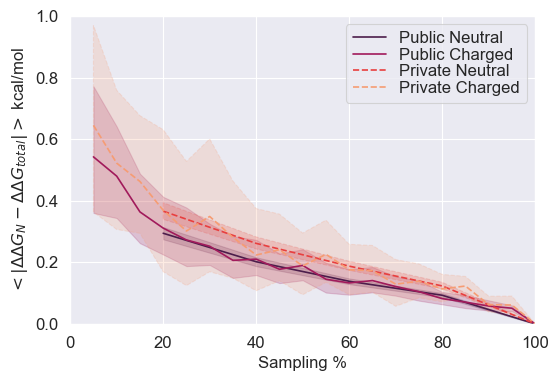

In [18]:
# plot the public and private data together
# make the figure and axes
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(6, 4))
# calculate the mean change between x and x+1 with 95% CI
nbootstrap = 1000
ci = 0.95

colors = sns.color_palette("rocket", 4)
c = 0
for dataset, ns_range, label, line in zip([pd.DataFrame(per_ns_ddgs_neutral), pd.DataFrame(per_ns_ddgs_charged), pd.DataFrame(per_ns_ddgs_neutral_private), pd.DataFrame(per_ns_ddgs_charged_private)],
                                           [5, 20, 5, 20],
                                           ["Public Neutral", "Public Charged", "Private Neutral", "Private Charged"],
                                           ["-", "-", "--", "--"]):

    # calculate the mean change between x and x+1 with 95% CI
    changes_in_ddg = []
    # get the final value using all simulation data
    for i in range(1, ns_range + 1):
        # get the DDG values for I sampling time
        temp_df = dataset[(dataset[f"Samples {i} ns DDG"].notna()) & (dataset[f"Samples {ns_range} ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
        # get the difference between this ns and the final value using all data
        change_in_ddg = abs(temp_df[f"Samples {i} ns DDG"] - temp_df[f"Samples {ns_range} ns DDG"])
        print(i, change_in_ddg.mean())

        mean_change = change_in_ddg.mean()
        # get the bootstrap CI
        mean_values = np.zeros(nbootstrap)
        for i in range(nbootstrap):
            sample_ids = np.random.choice(len(change_in_ddg), size=len(change_in_ddg), replace=True)
            sample_data = change_in_ddg[sample_ids]
            mean_values[i] = sample_data.mean()
        # get the 95% CI
        low = np.percentile(mean_values, 2.5)
        high = np.percentile(mean_values, 97.5)
        change_stats = {
            "mean change": mean_change,
            "extra ns": i,
            "low": low,
            "high": high
        }

        changes_in_ddg.append(change_stats)
    temp_change_df = pd.DataFrame(changes_in_ddg)
    print(temp_change_df)
    x_labels = [100 * (i / ns_range) for i in range(1, ns_range + 1)]
    plt.plot(x_labels, temp_change_df["mean change"], label=label, linestyle=line, color=colors[c])
    plt.fill_between(x_labels, temp_change_df["low"], temp_change_df["high"], alpha=0.2, linestyle=line, color=colors[c])
    c += 1
plt.ylim((0, 1))
plt.xlim((0, 100))
plt.legend(labelspacing=0.1, fontsize=12)
plt.xlabel("Sampling %", fontdict={"fontsize": 12})
plt.ylabel(r"$<|\Delta\Delta G_{N} - \Delta\Delta G_{total}|>$ kcal/mol", fontdict={"fontsize": 12})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("distance_to_final_ddg_percent_public_private.png", dpi=300, bbox_inches="tight")

In [19]:
neutral_private = pd.DataFrame(per_ns_ddgs_neutral_private)
neutral_private = neutral_private[(neutral_private["Samples 5 ns DDG"].notna()) & (neutral_private["Samples 1 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
change_in_private = abs(neutral_private["Samples 1 ns DDG"] - neutral_private["Samples 5 ns DDG"])
change_in_private.mean(), change_in_private.std()
# neutral_private["Samples 5 ns dDDG"].mean()

(0.3660993486916033, 0.5019673091703079)

In [20]:
import numpy as np
def plot_the_distance_to_final_ddg(dataset, ns_range, name):

    # get the final value using all simulation data
    for i in range(1, ns_range):
        # get the DDG values for I sampling time
        temp_df = dataset[(dataset[f"Samples {i} ns DDG"].notna()) & (dataset[f"Samples {ns_range} ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
        # get the difference between this ns and the final value using all data
        change_in_ddg = abs(temp_df[f"Samples {i} ns DDG"] - temp_df[f"Samples {ns_range} ns DDG"])
        print(i, change_in_ddg.mean())

        sns.ecdfplot(x=change_in_ddg, label=f"{i} ns", linewidth=2)
        # plot the mean uncertainty at the full simulation length as a vertical line
    plt.axvline(x=dataset[f"Samples {ns_range} ns dDDG"].mean(), color="k", linestyle='--', label=f"Average uncertainty at {ns_range} ns")
       
    plt.legend(labelspacing=0.1, fontsize=12)
    plt.ylabel("Proportion", fontdict={"fontsize": 12})
    plt.xlabel(r"$|\Delta\Delta G_{N} - \Delta\Delta G_{total}|$ kcal/mol", fontdict={"fontsize": 12})
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig(name, dpi=300, bbox_inches="tight")
    # plt.show()

1 0.2943250936665864
2 0.20185417530706862
3 0.13842970326367193
4 0.09306157506019075


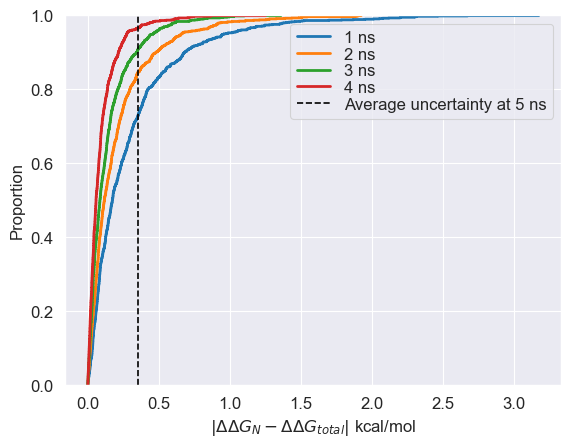

In [21]:
plot_the_distance_to_final_ddg(dataset=pd.DataFrame(per_ns_ddgs_neutral), ns_range=5, name="distance_to_final_ddg_neutral_public.png")

1 0.3660993486916033
2 0.2614795858345437
3 0.18756052938493128
4 0.12326861994702769


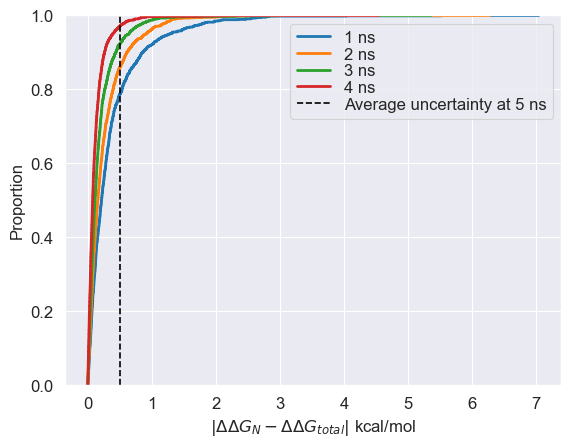

In [22]:
plot_the_distance_to_final_ddg(dataset=pd.DataFrame(per_ns_ddgs_neutral_private), ns_range=5, name="distance_to_final_ddg_neutral_private.png")

1 0.5424014352669585
2 0.47977565423541485
3 0.3636117710370412
4 0.3110460311608385
5 0.2725756459757409
6 0.2522446203975091
7 0.20635459390277705
8 0.21036079219413661
9 0.17741831831973306
10 0.18985984008944
11 0.14502633053363817
12 0.1330785503823108
13 0.14074964819683872
14 0.12136384089820358
15 0.10479787738025693
16 0.08209539964289386
17 0.07066227137585018
18 0.05808220066079361
19 0.050948973644944724


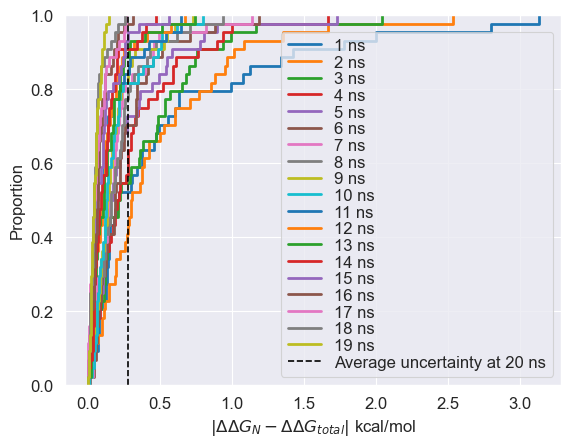

In [23]:
plot_the_distance_to_final_ddg(dataset=pd.DataFrame(per_ns_ddgs_charged), ns_range=20, name="distance_to_final_ddg_charged_public.png")

1 0.6447831188847858
2 0.5219918917205385
3 0.46237817269086207
4 0.36888337479539474
5 0.30164711399228306
6 0.3488179424967529
7 0.28096791653358805
8 0.22375972291364313
9 0.2410478191706963
10 0.18830453466319666
11 0.22599972120322293
12 0.1758860934908075
13 0.1727134555846624
14 0.1290246537271112
15 0.13864671569353712
16 0.11361583793450691
17 0.12298097704973461
18 0.06244954164938303
19 0.0613251312530733


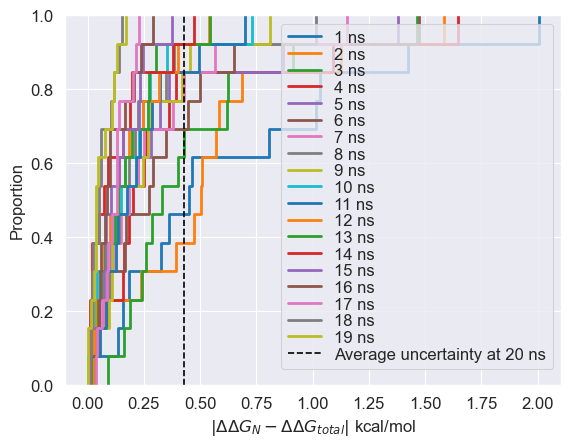

In [24]:
plot_the_distance_to_final_ddg(dataset=pd.DataFrame(per_ns_ddgs_charged_private), ns_range=20, name="distance_to_final_ddg_charged_private.png")

In [25]:
# get the number of neutral edges at 4ns with a distance lower than the average uncertainty at 5ns
neutral_df = pd.DataFrame(per_ns_ddgs_neutral_private)
neutral_df = neutral_df[(neutral_df["Samples 5 ns DDG"].notna()) & (neutral_df["Samples 4 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
# get the abs error
abs_diff = abs(neutral_df["Samples 4 ns DDG"] - neutral_df["Samples 5 ns DDG"])
no_edges = neutral_df[abs_diff < neutral_df["Samples 5 ns dDDG"].mean()]["Samples 4 ns DDG"].count()
no_edges / len(neutral_df) * 100

97.10896960711638

In [26]:
no_edges

1310

In [27]:
# same again for the charged edges
charged_df = pd.DataFrame(per_ns_ddgs_charged)
charged_df = charged_df[(charged_df["Samples 20 ns DDG"].notna()) & (charged_df["Samples 16 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
# get the abs error
abs_diff = abs(charged_df["Samples 16 ns DDG"] - charged_df["Samples 20 ns DDG"])
no_edges = charged_df[abs_diff < charged_df["Samples 20 ns dDDG"].mean()]["Samples 16 ns DDG"].count()
no_edges / len(charged_df) * 100

97.72727272727273

In [28]:
charged_df["Samples 20 ns dDDG"].mean()

0.28083172939603496

In [29]:
from scipy.stats import wilcoxon

# calculate the wilcoxon test for the neutral edges comparing the difference after 4 ns and 5ns
neutral_df = pd.DataFrame(per_ns_ddgs_neutral)
neutral_df = neutral_df[(neutral_df["Samples 5 ns DDG"].notna()) & (neutral_df["Samples 4 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
# calculate the signed difference
diff = neutral_df["Samples 5 ns DDG"] - neutral_df["Samples 4 ns DDG"]
# calculate the wilcoxon test
w, p = wilcoxon(diff)
print(f"Wilcoxon test: {w}, p-value: {p}")

Wilcoxon test: 304266.0, p-value: 0.059913104333569035


In [30]:
# calculate the wilcoxon test for the charged edges comparing the difference after 16 ns and 20ns
charged_df = pd.DataFrame(per_ns_ddgs_charged_private)
charged_df = charged_df[(charged_df["Samples 20 ns DDG"].notna()) & (charged_df["Samples 16 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
# calculate the signed difference
diff = charged_df["Samples 16 ns DDG"] - charged_df["Samples 20 ns DDG"]
# calculate the wilcoxon test
w, p = wilcoxon(diff)
print(f"Wilcoxon test: {w}, p-value: {p}")

Wilcoxon test: 25.0, p-value: 0.167724609375


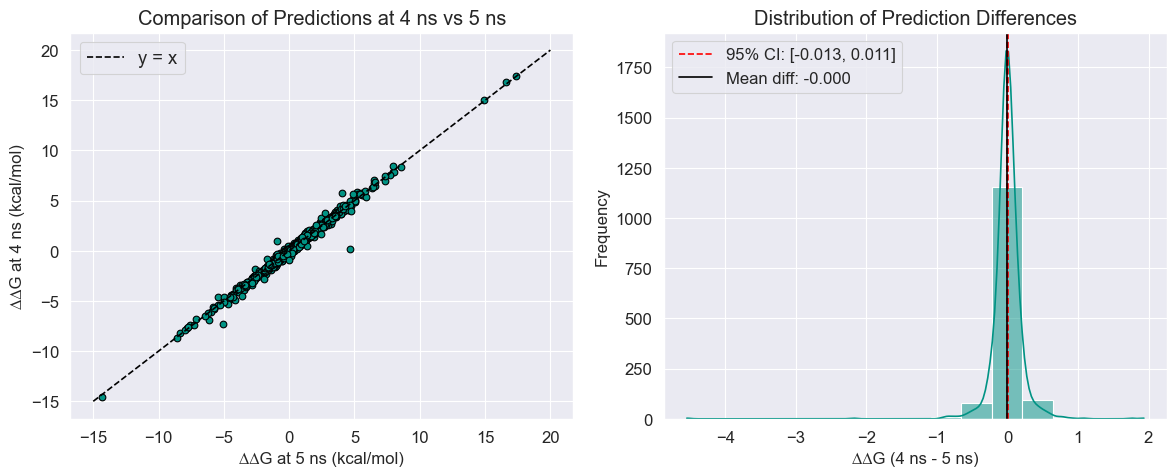

In [38]:
# calculate the bootstrap confidence interval for the difference between 4 ns and 5 ns
neutral_df = pd.DataFrame(per_ns_ddgs_neutral_private)
diffs = neutral_df["Samples 4 ns DDG"] - neutral_df["Samples 5 ns DDG"]
n_bootstrap = 1000
boot_diffs = []
n_edges = len(diffs)

for _ in range(n_bootstrap):
    sample = np.random.choice(diffs, size=n_edges, replace=True)
    boot_diffs.append(np.mean(sample))

ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)
mean_diff = np.mean(diffs)
# Plot: 4 ns vs 5 ns predictions and difference histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot of predictions
axs[0].scatter(neutral_df["Samples 5 ns DDG"], neutral_df["Samples 4 ns DDG"], color='#009384', edgecolor='k')
axs[0].plot([-15, 20], [-15, 20], 'k--', label='y = x')
axs[0].set_xlabel('∆∆G at 5 ns (kcal/mol)', fontdict={"fontsize": 12})
axs[0].set_ylabel('∆∆G at 4 ns (kcal/mol)', fontdict={"fontsize": 12})
# set the size of the xticks on the x axis
axs[0].tick_params(axis='x', labelsize=12)
# same for the y axis
axs[0].tick_params(axis='y', labelsize=12)
# axs[0].xticks(fontsize=12)
axs[0].set_title('Comparison of Predictions at 4 ns vs 5 ns')
axs[0].legend()
axs[0].grid(True)
# plt.xticks(fontsize=12)

# Histogram of differences
sns.histplot(diffs, bins=15, kde=True, ax=axs[1], color='#009384')
axs[1].axvline(ci_lower, color='red', linestyle='--', label=f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
axs[1].axvline(ci_upper, color='red', linestyle='--')
axs[1].axvline(mean_diff, color='black', linestyle='-', label=f"Mean diff: {mean_diff:.3f}")
axs[1].set_xlabel('∆∆G (4 ns - 5 ns)', fontdict={"fontsize": 12})
axs[1].set_ylabel('Frequency', fontdict={"fontsize": 12})
axs[1].set_title('Distribution of Prediction Differences')
axs[1].tick_params(axis='x', labelsize=12)
# same for the y axis
axs[1].tick_params(axis='y', labelsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True)

plt.tight_layout()
plt.savefig("4ns_vs_5ns_private.png", dpi=300, bbox_inches="tight")
# plt.show()

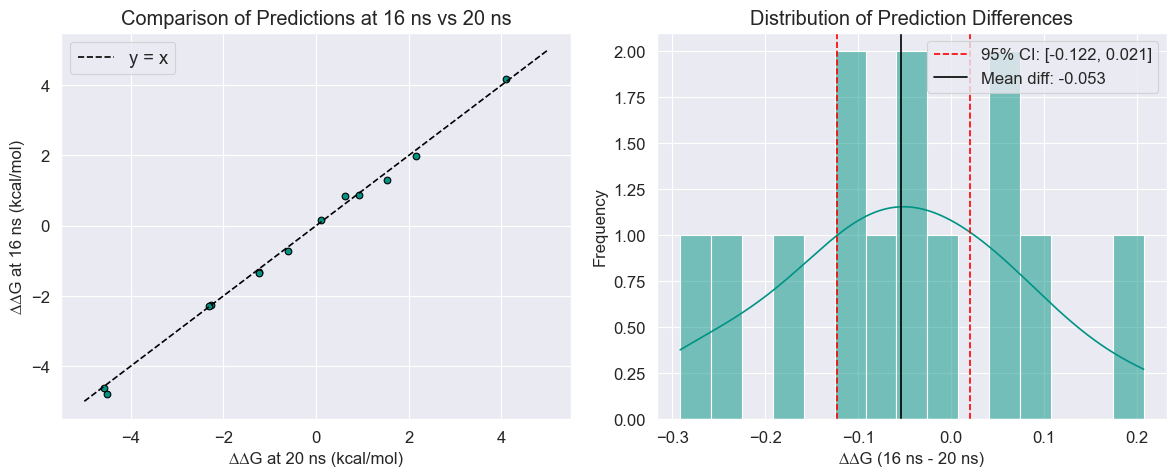

In [43]:
# plot the charged data
# calculate the bootstrap confidence interval for the difference between 16 ns and 20 ns
charged_df = pd.DataFrame(per_ns_ddgs_charged_private)
diffs = charged_df["Samples 16 ns DDG"] - charged_df["Samples 20 ns DDG"]
n_bootstrap = 1000
boot_diffs = []
n_edges = len(diffs)
for _ in range(n_bootstrap):
    sample = np.random.choice(diffs, size=n_edges, replace=True)
    boot_diffs.append(np.mean(sample))
ci_lower = np.percentile(boot_diffs, 2.5)
ci_upper = np.percentile(boot_diffs, 97.5)
mean_diff = np.mean(diffs)
# Plot: 16 ns vs 20 ns predictions and difference histogram
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Scatter plot of predictions
axs[0].scatter(charged_df["Samples 20 ns DDG"], charged_df["Samples 16 ns DDG"], color='#009384', edgecolor='k')
axs[0].plot([-5, 5], [-5, 5], 'k--', label='y = x')
axs[0].set_xlabel('∆∆G at 20 ns (kcal/mol)', fontdict={"fontsize": 12})
axs[0].set_ylabel('∆∆G at 16 ns (kcal/mol)', fontdict={"fontsize": 12})
# set the size of the xticks on the x axis
axs[0].tick_params(axis='x', labelsize=12)
# same for the y axis
axs[0].tick_params(axis='y', labelsize=12)
axs[0].set_title('Comparison of Predictions at 16 ns vs 20 ns')
axs[0].legend()
axs[0].grid(True)
# plt.xticks(fontsize=12)
# Histogram of differences
sns.histplot(diffs, bins=15, kde=True, ax=axs[1], color='#009384')
axs[1].axvline(ci_lower, color='red', linestyle='--', label=f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
axs[1].axvline(ci_upper, color='red', linestyle='--')
axs[1].axvline(mean_diff, color='black', linestyle='-', label=f"Mean diff: {mean_diff:.3f}")
axs[1].set_xlabel('∆∆G (16 ns - 20 ns)', fontdict={"fontsize": 12})
axs[1].set_ylabel('Frequency', fontdict={"fontsize": 12})
axs[1].set_title('Distribution of Prediction Differences')
axs[1].tick_params(axis='x', labelsize=12)
# same for the y axis
axs[1].tick_params(axis='y', labelsize=12)
axs[1].legend(fontsize=12)
axs[1].grid(True)
plt.tight_layout()
plt.savefig("16ns_vs_20ns_charged_private.png", dpi=300, bbox_inches="tight")
plt.show()

In [44]:
# load all of the molecules so we can create mapping plots
import pathlib
from rdkit import Chem
all_ligands = {}
name_conversions = {
    "41 flip": "41-flip",
    "40 flip": "40-flip",
    "38 flip": "38-flip",
    "30 flip": "30-flip",
    "43 flip": "43-flip",
    "47 flip": "47-flip",
    "48 flip": "48-flip",
    "46 flip": "46-flip",
    "36 out": "36o",
    "37 out": "37o",
    "38 out": "38o",
    "39 out": "39o",
    "28 out": "28o",
    "CHEMBL3402756_2.7 redocked": "CHEMBL3402756_2.7_redocked",
    "CHEMBL3402757_6.5 redocked" : "CHEMBL3402757_6.5_redocked",
    "CHEMBL3402758_10 redocked": "CHEMBL3402758_10_redocked",
    "CHEMBL3402760_1 redocked":"CHEMBL3402760_1_redocked",
    "CHEMBL3402762_1 redocked": "CHEMBL3402762_1_redocked",
    "CHEMBL3402759_5.7 redocked": "CHEMBL3402759_5.7_redocked",
    "CHEMBL3402761_1 redocked": "CHEMBL3402761_1_redocked",
    "Example 22":"Example-22",
    "Example 23": "Example-23",
    "Example 14": "Example-14",
    "Example 9": "Example-9",
    "SHP099-1 Example 7": "SHP099-1-Example-7",
    "Example 28": "Example-28",
    "Example 24": "Example-24",
    "Example 26": "Example-26",
    "Example 6": "Example-6",
    "Example 1": "Example-1",
    "Example 30": "Example-30",
    "Example 8": "Example-8",
    "Example 29": "Example-29",
    "Example 2": "Example-2",
    "Example 25": "Example-25",
    "Example 4": "Example-4",
    "Example 3": "Example-3",
    "Example 27": "Example-27",
    "Example 5": "Example-5",
    "9 flip": "9-flip",
}
key_to_ligand = {}
base_data_folder = pathlib.Path("/Users/joshua/Documents/Software/IndustryBenchmarks2024/industry_benchmarks/input_structures/prepared_structures")
for folder in base_data_folder.glob("*"):
    if folder.is_dir() and folder != "template":
        for target_ligs in folder.glob("*/ligands.sdf"):
            # load the ligands
            supplier = Chem.SDMolSupplier(target_ligs, removeHs=False)
            for lig in supplier:
                name = lig.GetProp("_Name")
                if name in name_conversions:
                    name = name_conversions[name]
                all_ligands[(name, target_ligs.parent.name, folder.name)] = Chem.GetFormalCharge(lig)
                key_to_ligand[(name, target_ligs.parent.name, folder.name)] = lig

In [45]:
from gufe import SmallMoleculeComponent
import kartograf
from kartograf.filters import (
    filter_ringbreak_changes,
    filter_ringsize_changes,
    filter_whole_rings_only,
)
from rdkit.Chem import Draw
import io
import cairosvg
from PIL import Image
grid_x, grid_y = 2, 1
from gufe.visualization.mapping_visualization import draw_mapping

def mapping_karto(liga, ligb, target, system):
    d2d = Draw.rdMolDraw2D.MolDraw2DSVG(grid_x * 300, grid_y * 300, 300, 300)
    mapping_filters = [
            filter_ringbreak_changes,  # default
            filter_ringsize_changes,  # default
            filter_whole_rings_only,  # default
        ]
    mapper = kartograf.KartografAtomMapper(
        atom_map_hydrogens=True,
        additional_mapping_filter_functions=mapping_filters,
    )
    ligand_a = SmallMoleculeComponent(key_to_ligand[(liga, target, system)])
    ligand_b = SmallMoleculeComponent(key_to_ligand[(ligb, target, system)])
    mapping =  next(mapper.suggest_mappings(ligand_a, ligand_b))
    svg_text = draw_mapping(mapping._compA_to_compB, mapping.componentA.to_rdkit(), mapping.componentB.to_rdkit(), d2d)
    png_data = cairosvg.svg2png(bytestring=svg_text.encode('utf-8'))
    image = Image.open(io.BytesIO(png_data))
    return image


We now want to plot the top 3 and bottom 3 transformations ranked by the absolute difference between the DDG estimate at 4ns vs 5ns as examples of slowly converging and fast converging edges.

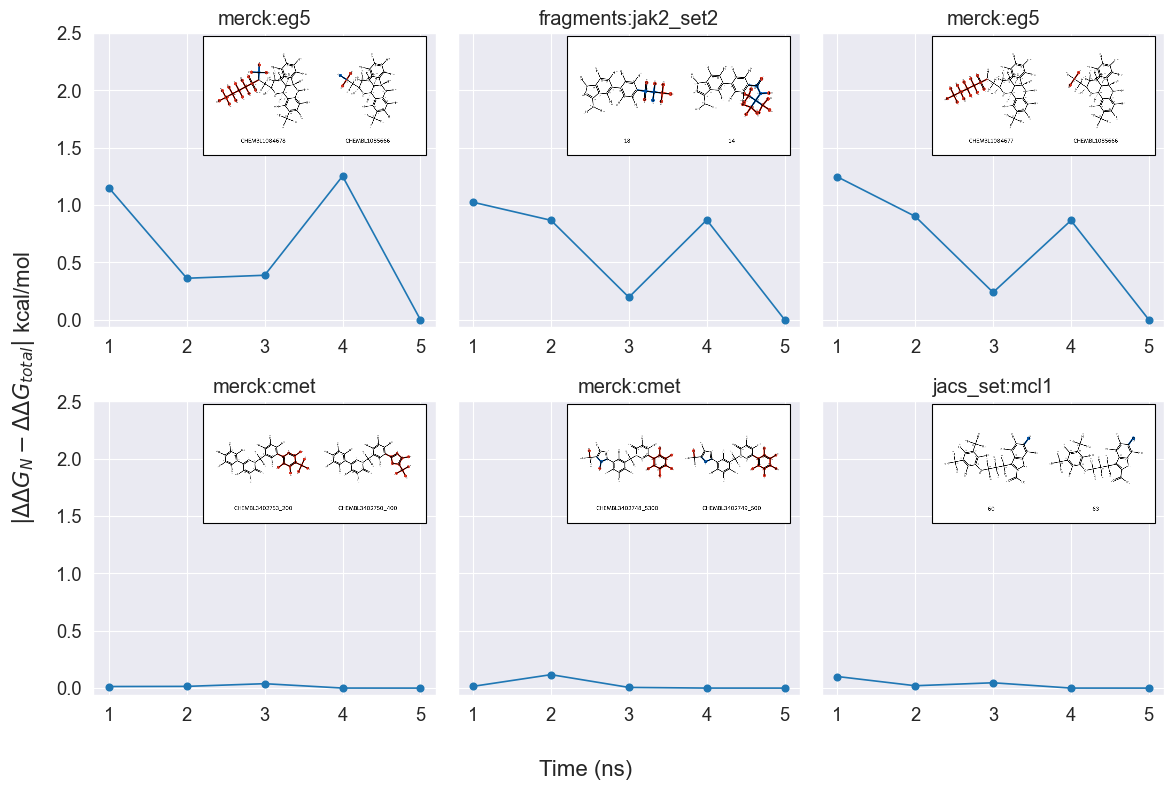

In [61]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# for the neutral edges get the absolute difference between the 4 ns and 5 ns predictions for the public data
neutral_df = pd.DataFrame(per_ns_ddgs_neutral)
neutral_df = neutral_df[(neutral_df["Samples 5 ns DDG"].notna()) & (neutral_df["Samples 4 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
# get the abs error
abs_diff = abs(neutral_df["Samples 4 ns DDG"] - neutral_df["Samples 5 ns DDG"])
# get the top 3 and bottom 3 edges by abs error after added the absolute difference to the dataframe
neutral_df["abs_diff"] = abs_diff
# sort the dataframe by the abs_diff column
neutral_df = neutral_df.sort_values(by="abs_diff", ascending=False)
# get the top 3 and bottom 3 edges
top_3_edges = neutral_df.head(3)
bottom_3_edges = neutral_df.tail(3)
# combine the two dataframes
selected_edges = pd.concat([top_3_edges, bottom_3_edges], ignore_index=True)
# Step 3: Plotting setup
n = 3
fig, axs = plt.subplots(2, n, figsize=(4 * n, 8), sharey=True)
axs = axs.flatten()
for i, row in selected_edges.iterrows():
    ax = axs[i]
    diffs = []
    for j in range(1, 6):
        diffs.append(abs(row[f"Samples {j} ns DDG"] - row[f"Samples {5} ns DDG"]))

    ax.plot(np.arange(1, 6), diffs, marker='o')
    ax.set_title(f"{row['system group']}:{row['system name']}")
    # ax.set_xlabel('Time (ns)')
    # ax.set_ylabel('ΔΔG (kcal/mol)')
    # ax.legend()

    # Optional: add molecule drawings
    img = mapping_karto(row["ligand_A"], row["ligand_B"], row["system name"], row["system group"])
    # img = Draw.MolsToImage([mol1, mol2], molsPerRow=2, subImgSize=(100,100))

    imagebox = OffsetImage(img, zoom=0.25)
    ab = AnnotationBbox(imagebox, (0.95, -0.01), frameon=True, xycoords='axes fraction',
                        box_alignment=(1, -1.75))
    ax.add_artist(ab)
plt.ylim(top=2.5)
fig.supxlabel('Time (ns)', fontsize=16)
fig.supylabel(r"$|\Delta\Delta G_{N} - \Delta\Delta G_{total}|$ kcal/mol", fontsize=16)
plt.tight_layout()
plt.savefig("top_bottom_3_edges_neutral.png", dpi=300, bbox_inches="tight")
# plt.show()

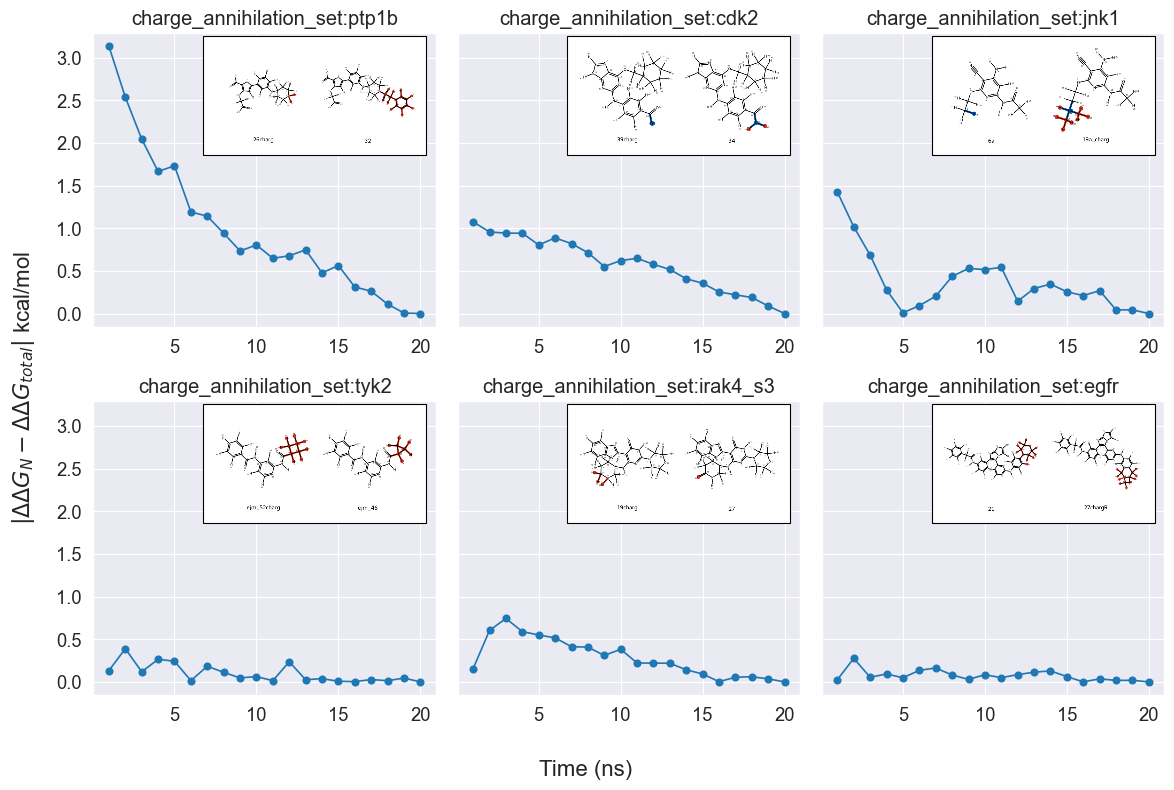

In [64]:
# same again for the charged edges
charged_df = pd.DataFrame(per_ns_ddgs_charged)
charged_df = charged_df[(charged_df["Samples 20 ns DDG"].notna()) & (charged_df["Samples 16 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
# get the abs error
abs_diff = abs(charged_df["Samples 16 ns DDG"] - charged_df["Samples 20 ns DDG"])
# get the top 3 and bottom 3 edges by abs error after added the absolute difference to the dataframe
charged_df["abs_diff"] = abs_diff
# sort the dataframe by the abs_diff column
charged_df = charged_df.sort_values(by="abs_diff", ascending=False)
# get the top 3 and bottom 3 edges
top_3_edges = charged_df.head(3)
bottom_3_edges = charged_df.tail(3)
# combine the two dataframes
selected_edges = pd.concat([top_3_edges, bottom_3_edges], ignore_index=True)
# Step 3: Plotting setup
n = 3
fig, axs = plt.subplots(2, n, figsize=(4 * n, 8), sharey=True)
axs = axs.flatten()
for i, row in selected_edges.iterrows():
    ax = axs[i]
    diffs = []
    for i in range(1, 21):
        diffs.append(abs(row[f"Samples {i} ns DDG"] - row[f"Samples {20} ns DDG"]))

    ax.plot(np.arange(1, 21), diffs, marker='o')
    ax.set_title(f"{row['system group']}:{row['system name']}")
    # ax.set_xlabel('Time (ns)')
    # ax.set_ylabel('ΔΔG (kcal/mol)')
    # ax.legend()

    # Optional: add molecule drawings
    img = mapping_karto(row["ligand_A"], row["ligand_B"], row["system name"], row["system group"])
    # img = Draw.MolsToImage([mol1, mol2], molsPerRow=2, subImgSize=(100,100))

    imagebox = OffsetImage(img, zoom=0.25)
    ab = AnnotationBbox(imagebox, (0.95, -0.01), frameon=True, xycoords='axes fraction',
                        box_alignment=(1, -1.75))
    ax.add_artist(ab)

fig.supxlabel('Time (ns)', fontsize=16)
fig.supylabel(r"$|\Delta\Delta G_{N} - \Delta\Delta G_{total}|$ kcal/mol", fontsize=16)
plt.tight_layout()
plt.savefig("top_bottom_3_edges_charged.png", dpi=300, bbox_inches="tight")

In [65]:
# create a new df which we can use for the boxplot, this should let use hue by public and private and have the change in DDG and the absolute error
# do public first
all_change_ddg_df = []
for dataset, label in zip([pd.DataFrame(per_ns_ddgs_neutral), pd.DataFrame(per_ns_ddgs_neutral_private)], ["Public", "Private"]):
    for _, row in dataset.iterrows():
        # get the change in DDG between 4 ns and 5 ns
        change_in_ddg = abs(row["Samples 4 ns DDG"] - row["Samples 5 ns DDG"])
        # get the absolute error
        abs_error = abs(row["exp DDG (kcal/mol)"] - row["Samples 5 ns DDG"])
        all_change_ddg_df.append({
            "Change in DDG 4-5 ns": "< 0.5" if change_in_ddg < 0.5 else "> 0.5",
            "abs DDG error": abs_error,
            "ligand_A": row["ligand_A"],
            "ligand_B": row["ligand_B"],
            "dataset": label
        })
all_change_ddg_df = pd.DataFrame(all_change_ddg_df)
all_change_ddg_df


,Change in DDG 4-5 ns,abs DDG error,ligand_A,ligand_B,dataset
0,< 0.5,0.406527,34,25,Public
1,< 0.5,0.161907,17charg,8,Public
2,< 0.5,0.433313,4charg,8,Public
3,< 0.5,0.487552,9,18,Public
4,< 0.5,0.834717,29charg,30charg,Public
...,...,...,...,...,...
2484,> 0.5,0.512154,ligand11,ligand12,Private
2485,> 0.5,2.252878,ligand0,ligand11,Private
2486,< 0.5,4.563770,ligand8,ligand3,Private
2487,> 0.5,2.836183,ligand2,ligand3,Private


In [66]:
all_change_ddg_df[(all_change_ddg_df["Change in DDG 4-5 ns"] == "> 0.5") & (all_change_ddg_df["dataset"] == "Public")].count()

Change in DDG 4-5 ns    18
abs DDG error           18
ligand_A                18
ligand_B                18
dataset                 18
dtype: int64

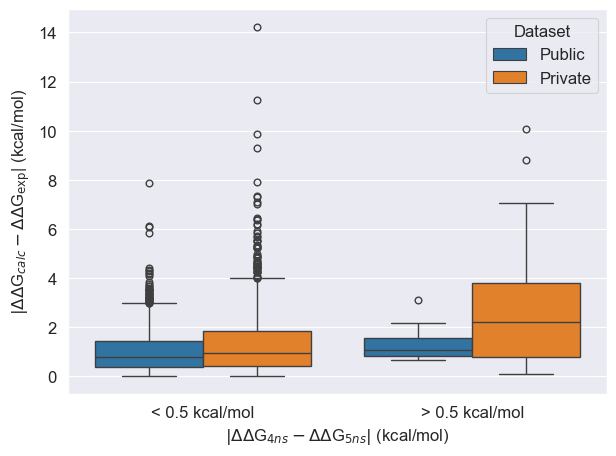

In [ ]:
# boxplot the absolute error distribution seperating edges with a change in ddg greater than 0.5 kcal/mol
sns.boxplot(data=all_change_ddg_df, x="Change in DDG 4-5 ns", y="abs DDG error", hue="dataset")
plt.ylabel(r"$|\Delta\Delta$G$_{calc} - \Delta\Delta$G$_{\text{exp}}$| (kcal/mol)", fontdict={"fontsize": 12})
plt.xticks([0, 1], ["< 0.5 kcal/mol", "> 0.5 kcal/mol"], fontsize=12)
plt.xlabel(r"$|\Delta\Delta$G$_{4ns} - \Delta\Delta$G$_{5ns}|$ (kcal/mol)", fontdict={"fontsize": 12})
plt.yticks(fontsize=12)
plt.legend(title="Dataset", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.savefig("absolute_error_boxplot_neutral_large_change_pub_private.png", dpi=300, bbox_inches="tight")

For the public and private datasets we now want to try and find a shift in the edge metrics if we split by the absolute change over the last nanosecond for the neutral edges.

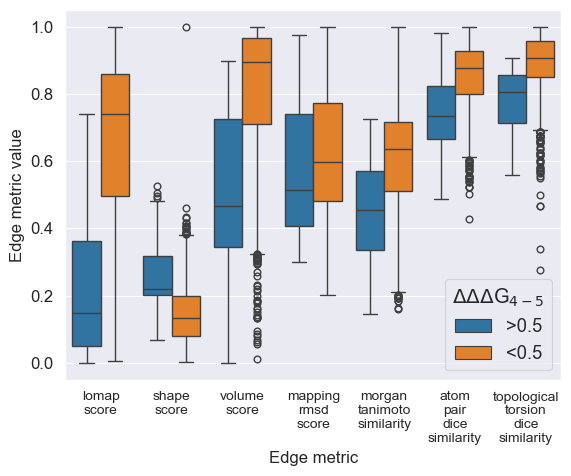

In [69]:
# get all neutral edges with a change in ddg greater than 0.5 kcal/mol
neutral_df = pd.DataFrame(per_ns_ddgs_neutral_private)
neutral_df = neutral_df[(neutral_df["Samples 5 ns DDG"].notna()) & (neutral_df["Samples 4 ns DDG"].notna())].copy(deep=True).reset_index(drop=True)
# get the abs error
abs_diff = abs(neutral_df["Samples 4 ns DDG"] - neutral_df["Samples 5 ns DDG"])
neutral_large_change_df = neutral_df[abs_diff >= 0.5].copy(deep=True).reset_index(drop=True)
neutral_small_change_df = neutral_df[abs_diff < 0.5].copy(deep=True).reset_index(drop=True)
# create a single dataframe with small and large changes and the edge metrics for a box plot
all_edge_data = []
for _, row in neutral_large_change_df.iterrows():
    for metric in ["lomap_score", "shape_score", "volume_score", "mapping_rmsd_score", "morgan_tanimoto_similarity", "atom_pair_dice_similarity", "topological_torsion_dice_similarity"]:
        # grab the row from the edge dataframe
        edge_row = private_edge_data[(private_edge_data["ligand_A"] == row["ligand_A"]) & (private_edge_data["ligand_B"] == row["ligand_B"]) & (private_edge_data["dataset_name"] == row["system name"]) & (private_edge_data["partner_id"] == row["partner"])].iloc[0]
        data = {
            "Change in DDG 4-5 ns": ">0.5" if abs(row["Samples 4 ns DDG"] - row["Samples 5 ns DDG"]) > 0.5 else "<0.5",
            "metric": metric.replace("_", "\n"),
            "value": edge_row[metric],
        }
        all_edge_data.append(data)
for _, row in neutral_small_change_df.iterrows():
    for metric in ["lomap_score", "shape_score", "volume_score", "mapping_rmsd_score", "morgan_tanimoto_similarity", "atom_pair_dice_similarity", "topological_torsion_dice_similarity"]:
        # grab the row from the edge dataframe
        edge_row = private_edge_data[(private_edge_data["ligand_A"] == row["ligand_A"]) & (private_edge_data["ligand_B"] == row["ligand_B"]) & (private_edge_data["dataset_name"] == row["system name"]) & (private_edge_data["partner_id"] == row["partner"])].iloc[0]
        data = {
            "Change in DDG 4-5 ns": "<0.5" if abs(row["Samples 4 ns DDG"] - row["Samples 5 ns DDG"]) < 0.5 else ">0.5",
            "metric": metric.replace("_", "\n"),
            "value": edge_row[metric],
        }
        all_edge_data.append(data)
all_edge_data_df = pd.DataFrame(all_edge_data)
# plot the boxplot
sns.boxplot(data=all_edge_data_df, x="metric", y="value", hue="Change in DDG 4-5 ns")
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
# rename the ledend title
plt.legend(title=r"$\Delta\Delta\Delta$G$_{4-5}$")
plt.ylabel("Edge metric value", fontdict={"fontsize": 12})
plt.xlabel("Edge metric", fontdict={"fontsize": 12})
plt.savefig("edge_metrics_boxplot_neutral_large_change_private.png", dpi=300, bbox_inches="tight")

In [70]:
def plot_uncert_distribution_per_ns(df, ns_range):
    all_data = []
    for i in range(1, ns_range + 1):
        # get the error for that many ns
        temp_df = df[df[f"Samples {i} ns dDDG"].notna()].copy(deep=True).reset_index(drop=True)
        for ddg_error in temp_df[f"Samples {i} ns dDDG"]:
            all_data.append(
                {"value": ddg_error, "ns": i}
            )
    tmp_all_data = pd.DataFrame(all_data)
    sns.boxplot(data=tmp_all_data, x="ns", y="value", order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.6, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None)
    plt.xlabel("Sampling ns")
    plt.ylabel(r"$dDDG_{N}$")
    plt.show()

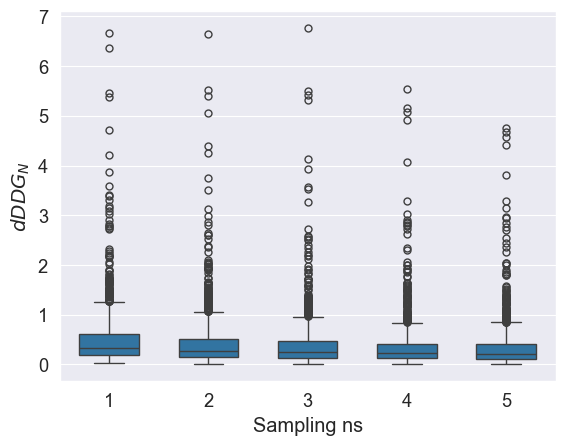

In [71]:
plot_uncert_distribution_per_ns(pd.DataFrame(per_ns_ddgs_neutral), 5)

In [ ]:
# we need to make a new df combinging the charged and neutral edges and get the estimates per 20% of the total simulation time
combined_per_ns_data = []
for _, row in normal_edge_data.iterrows():
    if np.isnan(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "system group": row["system group"],
        "system name": row["system name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each 1/5 of total ns
    temp_cumulative_data = cumulative_data[(cumulative_data["system group"] == row["system group"]) & (cumulative_data["system name"] == row["system name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]
    fith_sample_time = int(total_ns / 5)

    for i in range(fith_sample_time, total_ns + 1, fith_sample_time):
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    combined_per_ns_data.append(cumulative_data_row)
combined_per_ns_df = pd.DataFrame(combined_per_ns_data)
combined_per_ns_df


,system group,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,charge_annihilation_set,cdk2,34,25,0.050000,0.0,0,0.860925,0.213371,0.907366,0.380215,0.691372,0.233876,0.653207,0.222241,0.456528,0.253792
1,charge_annihilation_set,cdk2,39charg,34,-1.510000,0.0,-1,-3.675394,0.191886,-3.447293,0.459189,-3.310455,0.341398,-2.987109,0.135790,-2.734255,0.244470
2,charge_annihilation_set,cdk2,39charg,25,-1.460000,0.0,-1,-2.935219,0.294969,-3.161536,0.448534,-2.843697,0.286023,-2.708498,0.298596,-2.866959,0.355077
3,charge_annihilation_set,dlk,17charg,8,-0.070001,0.0,0,0.170391,1.052105,0.041609,0.207820,-0.083986,0.214797,-0.043059,0.149009,0.091906,0.229812
4,charge_annihilation_set,dlk,4charg,8,-1.180000,0.0,0,-1.762323,0.060808,-1.664459,0.195709,-1.526440,0.177870,-1.564452,0.203490,-1.613313,0.121454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,merck,pfkfb3,49,47,-0.399159,0.0,0,0.754273,0.365762,0.835334,0.239717,0.916750,0.452002,0.856560,0.298544,0.817963,0.325819
1180,merck,pfkfb3,65,29,-0.158121,0.0,0,0.497839,0.608575,0.270352,0.424172,0.566655,0.153471,0.297737,0.158709,0.485801,0.245501
1181,merck,pfkfb3,29,64,0.223740,0.0,0,0.815219,0.514712,0.182572,0.454080,-0.097836,0.504744,-0.233379,0.180472,-0.323246,0.434290
1182,merck,pfkfb3,47,46,0.474092,0.0,0,-0.960734,0.275127,-0.830226,0.123748,-0.834919,0.101930,-0.743177,0.068187,-0.649200,0.090989


In [73]:
# same again for the private data
combined_per_ns_data_private = []
for _, row in private_edge_data.iterrows():
    if np.isnan(row["exp DDG (kcal/mol)"]):
        continue
    if row["alchemical_charge_difference"] == 0:
        total_ns = 5
    else:
        total_ns = 20
    cumulative_data_row = {
        "partner": row["partner_id"],
        "system name": row["dataset_name"],
        "ligand_A": row["ligand_A"],
        "ligand_B": row["ligand_B"],
        "exp DDG (kcal/mol)": row["exp DDG (kcal/mol)"],
        "exp dDDG (kcal/mol)": row["exp dDDG (kcal/mol)"],
        "alchemical_charge_difference": row["alchemical_charge_difference"]
    }
    # workout the estimate of DDG for each 1/5 of total ns
    temp_cumulative_data = private_cumulative_data[(private_cumulative_data["partner_id"] == row["partner_id"]) & (private_cumulative_data["dataset_name"] == row["dataset_name"])].copy(deep=True).reset_index(drop=True)
    complex_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "complex")]
    solvent_data = temp_cumulative_data[(temp_cumulative_data["ligand_A"] == row["ligand_A"]) & (temp_cumulative_data["ligand_B"] == row["ligand_B"]) & (temp_cumulative_data["phase"] == "solvent")]
    fith_sample_time = int(total_ns / 5)

    for i in range(fith_sample_time, total_ns + 1, fith_sample_time):
        per_ns_complex = complex_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_complex_error = complex_data[f"Samples {i}ns (subsample) DG"].std()
        per_ns_solvent = solvent_data[f"Samples {i}ns (subsample) DG"].mean()
        per_ns_solvent_error = solvent_data[f"Samples {i}ns (subsample) DG"].std()
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% DDG"] = per_ns_complex - per_ns_solvent
        cumulative_data_row[f"Samples {int((i/total_ns)*100)}% dDDG"] = (per_ns_complex_error ** 2 + per_ns_solvent_error ** 2) ** 0.5
    combined_per_ns_data_private.append(cumulative_data_row)
combined_per_ns_df_private = pd.DataFrame(combined_per_ns_data_private)
combined_per_ns_df_private

,partner,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,ASAP,Enterovirus,unknown_ligand_3,unknown_ligand_15,1.148118,0.055056,0,1.104402,0.136664,1.065402,0.113571,1.032865,0.083231,1.014247,0.088905,0.972771,0.080710
1,ASAP,Enterovirus,unknown_ligand_15,unknown_ligand_21,0.327255,0.076637,0,0.245326,0.278446,0.195591,0.249188,0.272850,0.135000,0.287770,0.054534,0.272273,0.138030
2,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_7,0.286348,0.032221,0,0.358455,0.296355,0.201361,0.166809,0.184357,0.209376,0.190192,0.125339,0.233306,0.140381
3,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_16,0.818136,0.048821,0,1.374171,0.281929,1.511584,0.360573,1.582223,0.327791,1.612850,0.166287,1.551585,0.149926
4,ASAP,Enterovirus,unknown_ligand_12,unknown_ligand_18,0.081814,0.094843,0,0.719973,0.259692,0.514005,0.145581,0.554642,0.141535,0.676114,0.143471,0.640925,0.105705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,Roche,target_D,ligand11,ligand12,2.561862,0.000000,0,2.183941,0.643764,2.646980,1.818435,2.770566,1.919833,2.565152,1.541890,2.049708,2.341527
1358,Roche,target_D,ligand0,ligand11,0.302856,0.000000,0,-2.440365,2.131070,-2.894143,1.298871,-2.691206,1.873933,-2.788925,1.604416,-1.950022,0.976101
1359,Roche,target_D,ligand8,ligand3,0.848769,0.000000,0,4.751131,3.875424,4.503254,3.178729,5.037318,2.624681,5.701962,2.505028,5.412539,3.130187
1360,Roche,target_D,ligand2,ligand3,1.876150,0.000000,0,2.367006,0.806749,2.181063,1.901754,2.414469,1.931305,3.915554,1.627744,4.712334,0.231165


In [84]:
# plot the distribution of the change in DDG at N compared to the full data averaged across all datasets using the % of the sampling data
# to combine the charge changes with the neutral edges
sns.set_style("darkgrid")
sns.set_theme("paper")
def plot_distribution_of_ddg_distance_per_system(df):
    all_data = []
    for i in range(20, 120, 20):
        # get the DDG values for I sampling time
        temp_df = df[(df[f"Samples {i}% DDG"].notna()) & (df[f"Samples 100% DDG"].notna())].copy(deep=True).reset_index(drop=True)
        # for each system calculate the average
        for system in temp_df["system group"].unique():
            system_df = temp_df[temp_df["system group"] == system].copy(deep=True).reset_index(drop=True)
            for target in system_df["system name"].unique():
                target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
                # get the difference between this ns and the final value using all data
                mean_change_in_ddg = np.mean(abs(target_df[f"Samples {i}% DDG"] - target_df[f"Samples 100% DDG"]))
                all_data.append(
                    {"value": mean_change_in_ddg, "ns": i, "system group": system, "system name": target}
                )
    tmp_all_data = pd.DataFrame(all_data)
    # return tmp_all_data
    sns.boxplot(data=tmp_all_data, x="ns", y="value", order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.6, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None)
    # add annotations on the plot for the outliers for the 80% sampling boxplot 
    j = 0
    ha = "center"
    for i, row in tmp_all_data.iterrows():
        if row["ns"] != 80:
            continue
        if row["value"] > 0.2:
            print(row)
            # name conversion
            name_to_new_name = {"charge_annihilation_set": "charged", "miscellaneous_set": "misc"}
            system_group = name_to_new_name.get(row["system group"], row["system group"])
            if row["value"] > 0.3:
                x = 2.5
                offset = 0.2
                ha = "center"
            else:
                x = 4 - 0.24 * j
                offset = 0.1 * j
                j += 1
                if row["system name"] in ["shp2", "eg5"]:
                    ha = "left"
            plt.annotate(f"{system_group}:{row['system name']}", xy=(3, row["value"]), xytext=(x, row["value"] + offset), ha=ha, color='darkred', arrowprops=dict(arrowstyle='->', color='darkred', lw=1.2))
    plt.xlabel("Sampling %", fontdict={"fontsize": 12})
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel(r"$<|\Delta\Delta$G$_{N} - \Delta\Delta$G$_{total}|>_{system}$", fontdict={"fontsize": 12})
    plt.tight_layout()
    plt.savefig("distribution_of_ddg_distance_per_system.png", dpi=300, bbox_inches="tight")
    # plt.show()


value                          0.202665
ns                                   80
system group    charge_annihilation_set
system name                        cdk2
Name: 174, dtype: object
value                          0.360268
ns                                   80
system group    charge_annihilation_set
system name                       ptp1b
Name: 183, dtype: object
value           0.223335
ns                    80
system group       merck
system name          eg5
Name: 211, dtype: object
value           0.21504
ns                   80
system group      merck
system name        shp2
Name: 213, dtype: object
value                    0.203487
ns                             80
system group    miscellaneous_set
system name                  cdk8
Name: 218, dtype: object


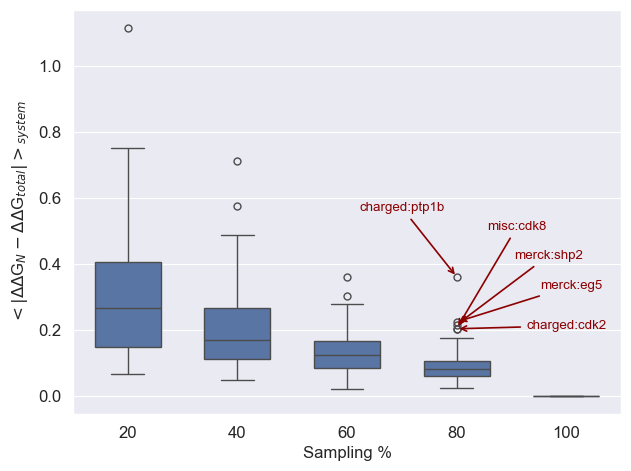

In [85]:
plot_distribution_of_ddg_distance_per_system(combined_per_ns_df)

In [87]:
# plot the private dataset
def plot_distribution_of_ddg_distance_per_system_private(df):
    all_data = []
    for i in range(20, 120, 20):
        # get the DDG values for I sampling time
        temp_df = df[(df[f"Samples {i}% DDG"].notna()) & (df[f"Samples 100% DDG"].notna())].copy(deep=True).reset_index(drop=True)
        # for each system calculate the average
        for system in temp_df["partner"].unique():
            system_df = temp_df[temp_df["partner"] == system].copy(deep=True).reset_index(drop=True)
            for target in system_df["system name"].unique():
                target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
                # get the difference between this ns and the final value using all data
                mean_change_in_ddg = np.mean(abs(target_df[f"Samples {i}% DDG"] - target_df[f"Samples 100% DDG"]))
                all_data.append(
                    {"value": mean_change_in_ddg, "ns": i, "system group": system, "system name": target}
                )
    tmp_all_data = pd.DataFrame(all_data)
    # return tmp_all_data
    sns.boxplot(data=tmp_all_data, x="ns", y="value", order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.6, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None)
    # add annotations on the plot for the outliers for the 80% sampling boxplot 
    j = 0
    for i, row in tmp_all_data.iterrows():
        if row["ns"] != 80:
            continue
        if row["value"] > 0.2:
            print(row)
            # name conversion
            name_to_new_name = {"bayer_macrocycles": "macrocycle", "charge_annihilation_set": "charged", "miscellaneous_set": "misc"}
            system_group = name_to_new_name.get(row["system group"], row["system group"])
            if row["value"] > 0.3:
                x = 3.5
                offset = 0.2
                ha = "center"
            else:
                ha = "center"
                x = 4 - 0.24 * j
                offset = 0.1 * j
                j += 1
                if row["system name"] in ["shp2", "eg5"]:
                    ha = "left"
            plt.annotate(f"{system_group}:{row['system name']}", xy=(3, row["value"]), xytext=(x, row["value"] + offset), ha=ha, color='darkred', arrowprops=dict(arrowstyle='->', color='darkred', lw=1.2))
    plt.xlabel("Sampling %", fontdict={"fontsize": 12})
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.ylabel(r"$<|\Delta\Delta$G$_{N} - \Delta\Delta$G$_{total}|>_{system}$", fontdict={"fontsize": 12})
    plt.tight_layout()
    # plt.savefig("distribution_of_ddg_distance_per_system_private.png", dpi=300, bbox_inches="tight")
    plt.show()

value           0.245764
ns                    80
system group    EliLilly
system name     Project1
Name: 126, dtype: object
value               0.257707
ns                        80
system group         Janssen
system name     systemB_set1
Name: 133, dtype: object
value           0.647411
ns                    80
system group       Roche
system name     target_D
Name: 147, dtype: object


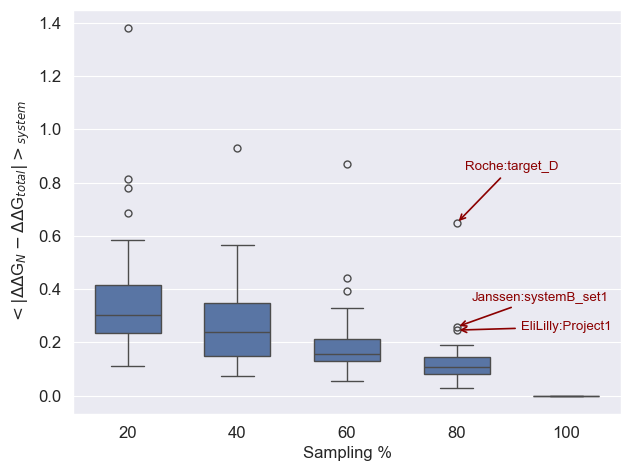

In [88]:
plot_distribution_of_ddg_distance_per_system_private(combined_per_ns_df_private)

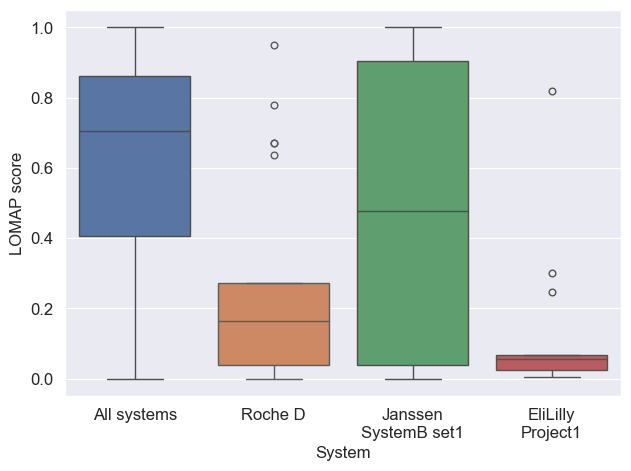

In [95]:
# For the slow converging private systems, plot the distribution of the LOMAP scores
roche_D = private_edge_data[(private_edge_data["partner_id"] != "Roche") & (private_edge_data["dataset_name"] != "target_D")].copy(deep=True).reset_index(drop=True)
# boxplot all of the private edge data 
sns.boxplot(data=private_edge_data, y="lomap_score", x=0)
for i, (partner, dataset_name) in enumerate([("Roche", "target_D"), ("Janssen", "systemB_set1"), ("EliLilly", "Project1")]):
    slow_dataset = private_edge_data[(private_edge_data["partner_id"] == partner) & (private_edge_data["dataset_name"] == dataset_name)].copy(deep=True).reset_index(drop=True)
    sns.boxplot(data=slow_dataset, y="lomap_score", x=(i + 1))
plt.ylabel("LOMAP score", fontdict={"fontsize": 12})
plt.xticks([0, 1, 2, 3], ["All systems", "Roche D", "Janssen\nSystemB set1", "EliLilly\nProject1"], fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("System", fontdict={"fontsize": 12})
plt.tight_layout()
# plt.show()
plt.savefig("lomap_score_boxplot_for_slow_private_systems.png", dpi=300, bbox_inches="tight")

Now we want to check the per-system edgewise DDG accuracy at 80 vs 100%. We have shown there is no significant difference over the whole set of edges but some systems show larger than average changes. Plotting the per-system accuracy should highlight this.


In [96]:
combined_per_ns_df

,system group,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,charge_annihilation_set,cdk2,34,25,0.050000,0.0,0,0.860925,0.213371,0.907366,0.380215,0.691372,0.233876,0.653207,0.222241,0.456528,0.253792
1,charge_annihilation_set,cdk2,39charg,34,-1.510000,0.0,-1,-3.675394,0.191886,-3.447293,0.459189,-3.310455,0.341398,-2.987109,0.135790,-2.734255,0.244470
2,charge_annihilation_set,cdk2,39charg,25,-1.460000,0.0,-1,-2.935219,0.294969,-3.161536,0.448534,-2.843697,0.286023,-2.708498,0.298596,-2.866959,0.355077
3,charge_annihilation_set,dlk,17charg,8,-0.070001,0.0,0,0.170391,1.052105,0.041609,0.207820,-0.083986,0.214797,-0.043059,0.149009,0.091906,0.229812
4,charge_annihilation_set,dlk,4charg,8,-1.180000,0.0,0,-1.762323,0.060808,-1.664459,0.195709,-1.526440,0.177870,-1.564452,0.203490,-1.613313,0.121454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,merck,pfkfb3,49,47,-0.399159,0.0,0,0.754273,0.365762,0.835334,0.239717,0.916750,0.452002,0.856560,0.298544,0.817963,0.325819
1180,merck,pfkfb3,65,29,-0.158121,0.0,0,0.497839,0.608575,0.270352,0.424172,0.566655,0.153471,0.297737,0.158709,0.485801,0.245501
1181,merck,pfkfb3,29,64,0.223740,0.0,0,0.815219,0.514712,0.182572,0.454080,-0.097836,0.504744,-0.233379,0.180472,-0.323246,0.434290
1182,merck,pfkfb3,47,46,0.474092,0.0,0,-0.960734,0.275127,-0.830226,0.123748,-0.834919,0.101930,-0.743177,0.068187,-0.649200,0.090989


In [ ]:
# make a new dataframe with the edgewise RMSE metrics per-system at 80% and 100% sampling
edgewise_rmse_data = []
import copy
nbootstrap = 1000
for system in combined_per_ns_df["system group"].unique():
    system_df = combined_per_ns_df[combined_per_ns_df["system group"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["system name"].unique():
        print(f"Calculating RMSE for {system}:{target}")
        target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
        # get the RMSE for 80% and 100% sampling
        
        rmse_80 = np.sqrt(np.mean((target_df["Samples 80% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        rmse_100 = np.sqrt(np.mean((target_df["Samples 100% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        # bootstrap the RMSE for 80% and 100% sampling
        rmse_80_bootstrap, rmse_100_bootstrap = np.zeros(nbootstrap), np.zeros(nbootstrap)
        for i in range(nbootstrap):
            sample_df = target_df.sample(frac=1, replace=True)
            rmse_80_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 80% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
            rmse_100_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 100% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
        # calculate the 95% CI for the RMSE
        ci_80_low = np.percentile(rmse_80_bootstrap, 2.5)
        ci_80_high = np.percentile(rmse_80_bootstrap, 97.5)
        ci_100_low = np.percentile(rmse_100_bootstrap, 2.5)
        ci_100_high = np.percentile(rmse_100_bootstrap, 97.5)
        edgewise_rmse_data.append({
            "system group": system,
            "system name": target,
            "RMSE 80%": rmse_80,
            "RMSE 100%": rmse_100,
            "RMSE 80% CI low": ci_80_low,
            "RMSE 80% CI high": ci_80_high,
            "RMSE 100% CI low": ci_100_low,
            "RMSE 100% CI high": ci_100_high,
            "N_edges": len(target_df),
        })
edgewise_rmse_df = pd.DataFrame(edgewise_rmse_data)
edgewise_rmse_df

Calculating RMSE for charge_annihilation_set:cdk2
Calculating RMSE for charge_annihilation_set:dlk
Calculating RMSE for charge_annihilation_set:egfr
Calculating RMSE for charge_annihilation_set:ephx2
Calculating RMSE for charge_annihilation_set:irak4_s2
Calculating RMSE for charge_annihilation_set:irak4_s3
Calculating RMSE for charge_annihilation_set:itk
Calculating RMSE for charge_annihilation_set:jak1
Calculating RMSE for charge_annihilation_set:jnk1
Calculating RMSE for charge_annihilation_set:ptp1b
Calculating RMSE for charge_annihilation_set:thrombin
Calculating RMSE for charge_annihilation_set:tyk2
Calculating RMSE for fragments:hsp90_2rings
Calculating RMSE for fragments:hsp90_single_ring
Calculating RMSE for fragments:jak2_set1
Calculating RMSE for fragments:jak2_set2
Calculating RMSE for fragments:liga
Calculating RMSE for fragments:mcl1
Calculating RMSE for fragments:mup1
Calculating RMSE for fragments:p38
Calculating RMSE for fragments:t4_lysozyme
Calculating RMSE for jacs_s

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,charge_annihilation_set,cdk2,1.169680,1.102058,0.603207,1.477109,0.406527,1.406959,3
1,charge_annihilation_set,dlk,0.920574,0.962016,0.356834,1.307489,0.401215,1.308223,6
2,charge_annihilation_set,egfr,2.004310,2.020741,1.261325,2.752478,1.326585,2.730168,7
3,charge_annihilation_set,ephx2,0.971273,0.894054,0.635054,1.140449,0.552554,1.137254,4
4,charge_annihilation_set,irak4_s2,1.332802,1.347623,0.869555,1.705527,0.842391,1.744768,7
5,charge_annihilation_set,irak4_s3,0.927441,0.925599,0.486180,1.281350,0.334878,1.265434,4
6,charge_annihilation_set,itk,1.298730,1.308476,0.745785,1.800556,0.759686,1.786948,5
7,charge_annihilation_set,jak1,1.319928,1.303528,0.801437,1.750734,0.749619,1.754765,7
8,charge_annihilation_set,jnk1,1.770678,1.609170,1.398555,2.077173,1.301287,1.866951,2
9,charge_annihilation_set,ptp1b,2.946179,2.886906,0.890300,3.995389,1.594128,3.684566,3


In [102]:
# add the weighted RMSE for the overall datasets
rmse_80, rmse_100 = np.zeros(nbootstrap), np.zeros(nbootstrap)
for i in range(nbootstrap):
    # bootstrap the data
    bootstrapped_data = edgewise_rmse_df.sample(n=len(edgewise_rmse_df), replace=True)
    rmse_80[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 80%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    rmse_100[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 100%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    

row_data = {
    "system name": "Weighted\nRMSE",
    "system group": "Overall",
    "RMSE 80%": np.mean(rmse_80),
    "RMSE 100%": np.mean(rmse_100),
    "RMSE 80% CI low": np.percentile(rmse_80, 2.5),
    "RMSE 80% CI high": np.percentile(rmse_80, 97.5),
    "RMSE 100% CI low": np.percentile(rmse_100, 2.5),
    "RMSE 100% CI high": np.percentile(rmse_100, 97.5),
    "N_edges": edgewise_rmse_df["N_edges"].sum(),
}
# add the row to the dataframe using concat
edgewise_rmse_df = pd.concat([edgewise_rmse_df, pd.DataFrame([row_data])], ignore_index=True)
edgewise_rmse_df

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,charge_annihilation_set,cdk2,1.169680,1.102058,0.603207,1.477109,0.406527,1.406959,3
1,charge_annihilation_set,dlk,0.920574,0.962016,0.356834,1.307489,0.401215,1.308223,6
2,charge_annihilation_set,egfr,2.004310,2.020741,1.261325,2.752478,1.326585,2.730168,7
3,charge_annihilation_set,ephx2,0.971273,0.894054,0.635054,1.140449,0.552554,1.137254,4
4,charge_annihilation_set,irak4_s2,1.332802,1.347623,0.869555,1.705527,0.842391,1.744768,7
5,charge_annihilation_set,irak4_s3,0.927441,0.925599,0.486180,1.281350,0.334878,1.265434,4
6,charge_annihilation_set,itk,1.298730,1.308476,0.745785,1.800556,0.759686,1.786948,5
7,charge_annihilation_set,jak1,1.319928,1.303528,0.801437,1.750734,0.749619,1.754765,7
8,charge_annihilation_set,jnk1,1.770678,1.609170,1.398555,2.077173,1.301287,1.866951,2
9,charge_annihilation_set,ptp1b,2.946179,2.886906,0.890300,3.995389,1.594128,3.684566,3


{'Overall': 60, 'charge_annihilation_set': 12, 'fragments': 21, 'jacs_set': 29, 'janssen_bace': 33, 'mcs_docking_set': 35, 'merck': 43, 'miscellaneous_set': 48, 'scaffold_hopping_set': 50, 'water_set': 58}


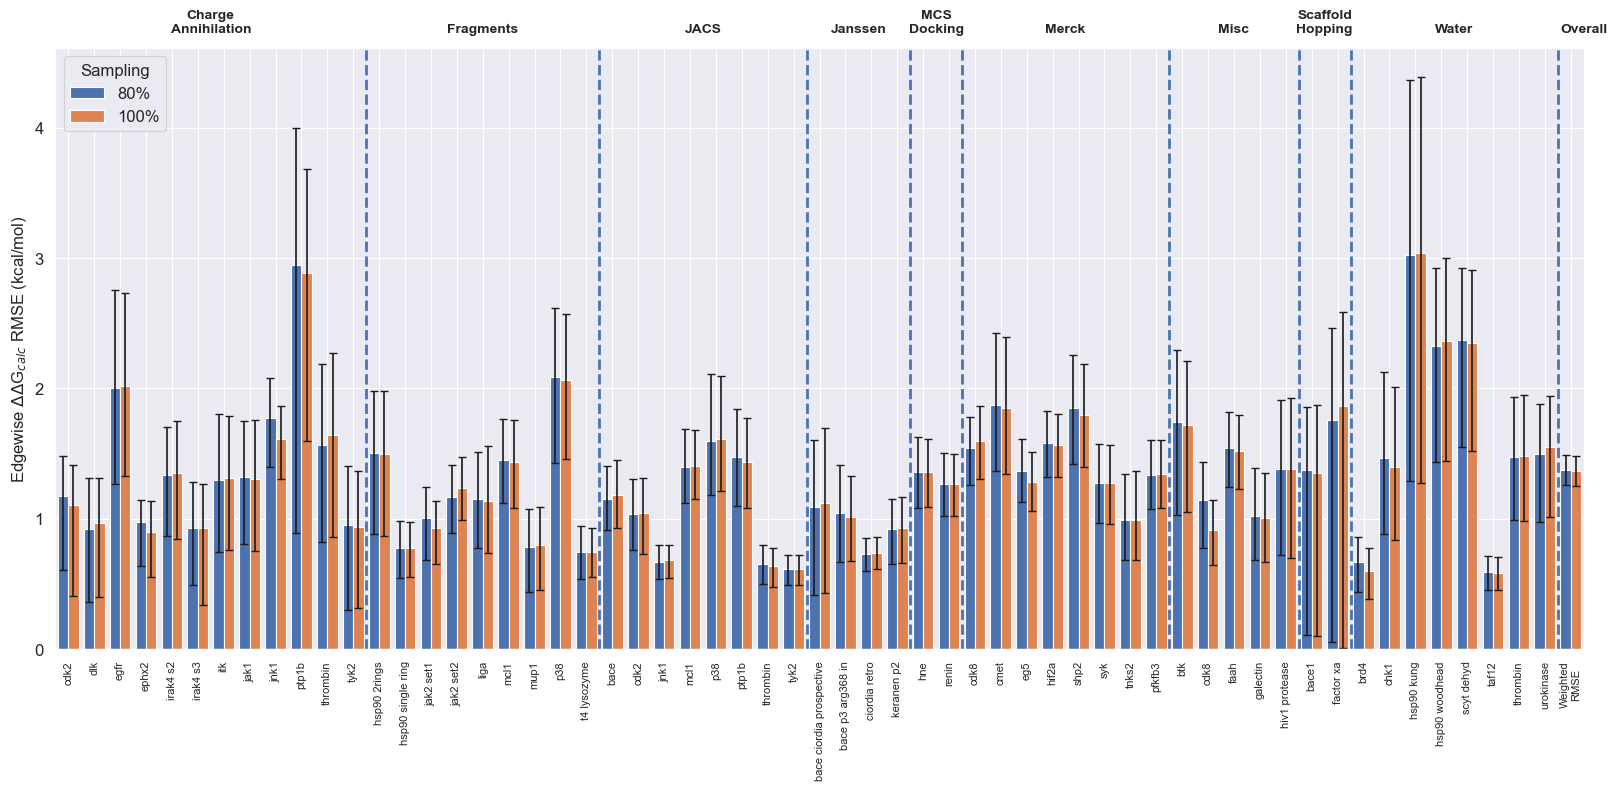

In [111]:
# plot the edgewise RMSE for 80% and 100% sampling
x = np.arange(len(edgewise_rmse_df))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.4

# Plot bars with error bars
rmse_err_80 = [edgewise_rmse_df['RMSE 80%'] - edgewise_rmse_df['RMSE 80% CI low'], edgewise_rmse_df['RMSE 80% CI high'] - edgewise_rmse_df['RMSE 80%']]
rmse_err_100 = [edgewise_rmse_df['RMSE 100%'] - edgewise_rmse_df['RMSE 100% CI low'], edgewise_rmse_df['RMSE 100% CI high'] - edgewise_rmse_df['RMSE 100%']]
# "OpenFE": "#009384", "FEP+": "#d9c4b1"
ax.bar(x - bar_width/2, edgewise_rmse_df['RMSE 80%'], yerr=rmse_err_80, width=bar_width, label='80%', capsize=3)
ax.bar(x + bar_width/2, edgewise_rmse_df['RMSE 100%'], yerr=rmse_err_100, width=bar_width, label='100%', capsize=3)

# Set labels and ticks
ax.set_xticks(x)
names = edgewise_rmse_df['system name'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=8)
ax.set_ylabel(r"Edgewise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontdict={"fontsize": 12})
# ax.set_title("Per-System RMSE and MUE with 95% Confidence Intervals")
ax.legend()

# Add colored background for classes
unique_classes = edgewise_rmse_df['system group'].unique()
# remove overall from the unique classes and add it to the end
unique_classes = [cls for cls in unique_classes if cls != "Overall"]
unique_classes.append("Overall")
class_bounds = edgewise_rmse_df.groupby('system group').size().cumsum().to_dict()
# move overall to the end
class_bounds["Overall"] = len(edgewise_rmse_df) + 1

for cls, bound in class_bounds.items():
    if cls == "Overall":
        continue
    class_bounds[cls] = bound - 1  # Adjust to match the last index of the class
print(class_bounds)
class_start = 0

colors = sns.color_palette("colorblind", len(unique_classes))
class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls]
    # add dashed lines for the span but not the fill
    if cls != "charge_annihilation_set":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
#     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=10, weight='bold')
    class_start = end

plt.tight_layout()
plt.legend(title="Sampling", fontsize=12, title_fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.5, len(edgewise_rmse_df) - 0.5)
# plt.show()
plt.savefig("per_system_edgewise_rmse_sampling_public.png", dpi=300, bbox_inches='tight')

In [112]:
combined_per_ns_df_private

,partner,system name,ligand_A,ligand_B,exp DDG (kcal/mol),exp dDDG (kcal/mol),alchemical_charge_difference,Samples 20% DDG,Samples 20% dDDG,Samples 40% DDG,Samples 40% dDDG,Samples 60% DDG,Samples 60% dDDG,Samples 80% DDG,Samples 80% dDDG,Samples 100% DDG,Samples 100% dDDG
0,ASAP,Enterovirus,unknown_ligand_3,unknown_ligand_15,1.148118,0.055056,0,1.104402,0.136664,1.065402,0.113571,1.032865,0.083231,1.014247,0.088905,0.972771,0.080710
1,ASAP,Enterovirus,unknown_ligand_15,unknown_ligand_21,0.327255,0.076637,0,0.245326,0.278446,0.195591,0.249188,0.272850,0.135000,0.287770,0.054534,0.272273,0.138030
2,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_7,0.286348,0.032221,0,0.358455,0.296355,0.201361,0.166809,0.184357,0.209376,0.190192,0.125339,0.233306,0.140381
3,ASAP,Enterovirus,unknown_ligand_4,unknown_ligand_16,0.818136,0.048821,0,1.374171,0.281929,1.511584,0.360573,1.582223,0.327791,1.612850,0.166287,1.551585,0.149926
4,ASAP,Enterovirus,unknown_ligand_12,unknown_ligand_18,0.081814,0.094843,0,0.719973,0.259692,0.514005,0.145581,0.554642,0.141535,0.676114,0.143471,0.640925,0.105705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1357,Roche,target_D,ligand11,ligand12,2.561862,0.000000,0,2.183941,0.643764,2.646980,1.818435,2.770566,1.919833,2.565152,1.541890,2.049708,2.341527
1358,Roche,target_D,ligand0,ligand11,0.302856,0.000000,0,-2.440365,2.131070,-2.894143,1.298871,-2.691206,1.873933,-2.788925,1.604416,-1.950022,0.976101
1359,Roche,target_D,ligand8,ligand3,0.848769,0.000000,0,4.751131,3.875424,4.503254,3.178729,5.037318,2.624681,5.701962,2.505028,5.412539,3.130187
1360,Roche,target_D,ligand2,ligand3,1.876150,0.000000,0,2.367006,0.806749,2.181063,1.901754,2.414469,1.931305,3.915554,1.627744,4.712334,0.231165


In [113]:
# do the same again for the private data
edgewise_rmse_data_private = []
import copy
nbootstrap = 1000
for system in combined_per_ns_df_private["partner"].unique():
    system_df = combined_per_ns_df_private[combined_per_ns_df_private["partner"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["system name"].unique():
        print(f"Calculating RMSE for {system}:{target}")
        target_df = system_df[system_df["system name"] == target].copy(deep=True).reset_index(drop=True)
        # get the RMSE for 80% and 100% sampling
        
        rmse_80 = np.sqrt(np.mean((target_df["Samples 80% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        rmse_100 = np.sqrt(np.mean((target_df["Samples 100% DDG"] - target_df["exp DDG (kcal/mol)"]) ** 2))
        # bootstrap the RMSE for 80% and 100% sampling
        rmse_80_bootstrap, rmse_100_bootstrap = np.zeros(nbootstrap), np.zeros(nbootstrap)
        for i in range(nbootstrap):
            sample_df = target_df.sample(frac=1, replace=True)
            rmse_80_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 80% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
            rmse_100_bootstrap[i] = np.sqrt(np.mean((sample_df["Samples 100% DDG"] - sample_df["exp DDG (kcal/mol)"]) ** 2))
        # calculate the 95% CI for the RMSE
        ci_80_low = np.percentile(rmse_80_bootstrap, 2.5)
        ci_80_high = np.percentile(rmse_80_bootstrap, 97.5)
        ci_100_low = np.percentile(rmse_100_bootstrap, 2.5)
        ci_100_high = np.percentile(rmse_100_bootstrap, 97.5)
        edgewise_rmse_data_private.append({
            "system group": system,
            "system name": target,
            "RMSE 80%": rmse_80,
            "RMSE 100%": rmse_100,
            "RMSE 80% CI low": ci_80_low,
            "RMSE 80% CI high": ci_80_high,
            "RMSE 100% CI low": ci_100_low,
            "RMSE 100% CI high": ci_100_high,
            "N_edges": len(target_df),
        })
edgewise_rmse_df_private = pd.DataFrame(edgewise_rmse_data_private)
edgewise_rmse_df_private

Calculating RMSE for ASAP:Enterovirus
Calculating RMSE for ASAP:MERS
Calculating RMSE for ASAP:SARS2-Mpro
Calculating RMSE for AbbVie:AbbVie_private_A
Calculating RMSE for AbbVie:AbbVie_private_B
Calculating RMSE for BI:systemB
Calculating RMSE for BI:systemC
Calculating RMSE for BI:systemD
Calculating RMSE for BI:systemE
Calculating RMSE for BI:systemF
Calculating RMSE for BI:systemG
Calculating RMSE for BI:systemH
Calculating RMSE for BI:systemI
Calculating RMSE for BI:systemK
Calculating RMSE for EliLilly:Project0
Calculating RMSE for EliLilly:Project1
Calculating RMSE for EliLilly:Project2
Calculating RMSE for GSK:GSK_PRIVATE_1
Calculating RMSE for GSK:GSK_PRIVATE_2
Calculating RMSE for Genentech:GNE_Private
Calculating RMSE for Janssen:systemA_set1
Calculating RMSE for Janssen:systemA_set2
Calculating RMSE for Janssen:systemB_set1
Calculating RMSE for Janssen:systemC_set1
Calculating RMSE for Janssen:systemD_set1
Calculating RMSE for Merck:merck_private_G
Calculating RMSE for Merc

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,ASAP,Enterovirus,0.465237,0.422656,0.284100,0.608493,0.263604,0.543029,14
1,ASAP,MERS,1.189177,1.134112,0.775794,1.570156,0.717569,1.503017,20
2,ASAP,SARS2-Mpro,0.862250,0.874368,0.664296,1.050370,0.688333,1.052093,44
3,AbbVie,AbbVie_private_A,1.873495,1.863700,1.148048,2.565932,1.145494,2.564687,26
4,AbbVie,AbbVie_private_B,1.412407,1.418850,1.111848,1.718032,1.123934,1.734272,29
5,BI,systemB,1.964319,1.947296,1.507436,2.390248,1.465516,2.397312,17
6,BI,systemC,2.291301,2.264186,1.759637,2.738160,1.778607,2.687586,18
7,BI,systemD,1.052465,1.055158,0.813217,1.247976,0.824636,1.248010,39
8,BI,systemE,2.982341,3.074102,1.889185,3.919854,1.957516,4.018013,15
9,BI,systemF,1.320924,1.337760,0.780087,1.771906,0.781153,1.805776,16


In [114]:
# add the weighted RMSE for the overall datasets
rmse_80, rmse_100 = np.zeros(nbootstrap), np.zeros(nbootstrap)
for i in range(nbootstrap):
    # bootstrap the data
    bootstrapped_data = edgewise_rmse_df_private.sample(n=len(edgewise_rmse_df_private), replace=True)
    rmse_80[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 80%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    rmse_100[i] = np.sqrt(np.sum(bootstrapped_data["RMSE 100%"] ** 2 * bootstrapped_data["N_edges"]) / np.sum(bootstrapped_data["N_edges"]))
    

row_data = {
    "system name": "Weighted\nRMSE",
    "system group": "Overall",
    "RMSE 80%": np.mean(rmse_80),
    "RMSE 100%": np.mean(rmse_100),
    "RMSE 80% CI low": np.percentile(rmse_80, 2.5),
    "RMSE 80% CI high": np.percentile(rmse_80, 97.5),
    "RMSE 100% CI low": np.percentile(rmse_100, 2.5),
    "RMSE 100% CI high": np.percentile(rmse_100, 97.5),
    "N_edges": edgewise_rmse_df_private["N_edges"].sum(),
}
# add the row to the dataframe using concat
edgewise_rmse_df_private = pd.concat([edgewise_rmse_df_private, pd.DataFrame([row_data])], ignore_index=True)
edgewise_rmse_df_private

,system group,system name,RMSE 80%,RMSE 100%,RMSE 80% CI low,RMSE 80% CI high,RMSE 100% CI low,RMSE 100% CI high,N_edges
0,ASAP,Enterovirus,0.465237,0.422656,0.284100,0.608493,0.263604,0.543029,14
1,ASAP,MERS,1.189177,1.134112,0.775794,1.570156,0.717569,1.503017,20
2,ASAP,SARS2-Mpro,0.862250,0.874368,0.664296,1.050370,0.688333,1.052093,44
3,AbbVie,AbbVie_private_A,1.873495,1.863700,1.148048,2.565932,1.145494,2.564687,26
4,AbbVie,AbbVie_private_B,1.412407,1.418850,1.111848,1.718032,1.123934,1.734272,29
5,BI,systemB,1.964319,1.947296,1.507436,2.390248,1.465516,2.397312,17
6,BI,systemC,2.291301,2.264186,1.759637,2.738160,1.778607,2.687586,18
7,BI,systemD,1.052465,1.055158,0.813217,1.247976,0.824636,1.248010,39
8,BI,systemE,2.982341,3.074102,1.889185,3.919854,1.957516,4.018013,15
9,BI,systemF,1.320924,1.337760,0.780087,1.771906,0.781153,1.805776,16


{'ASAP': 3, 'AbbVie': 5, 'BI': 14, 'EliLilly': 17, 'GSK': 19, 'Genentech': 20, 'Janssen': 25, 'Merck': 27, 'Odyssey': 28, 'Overall': 39, 'Roche': 37}


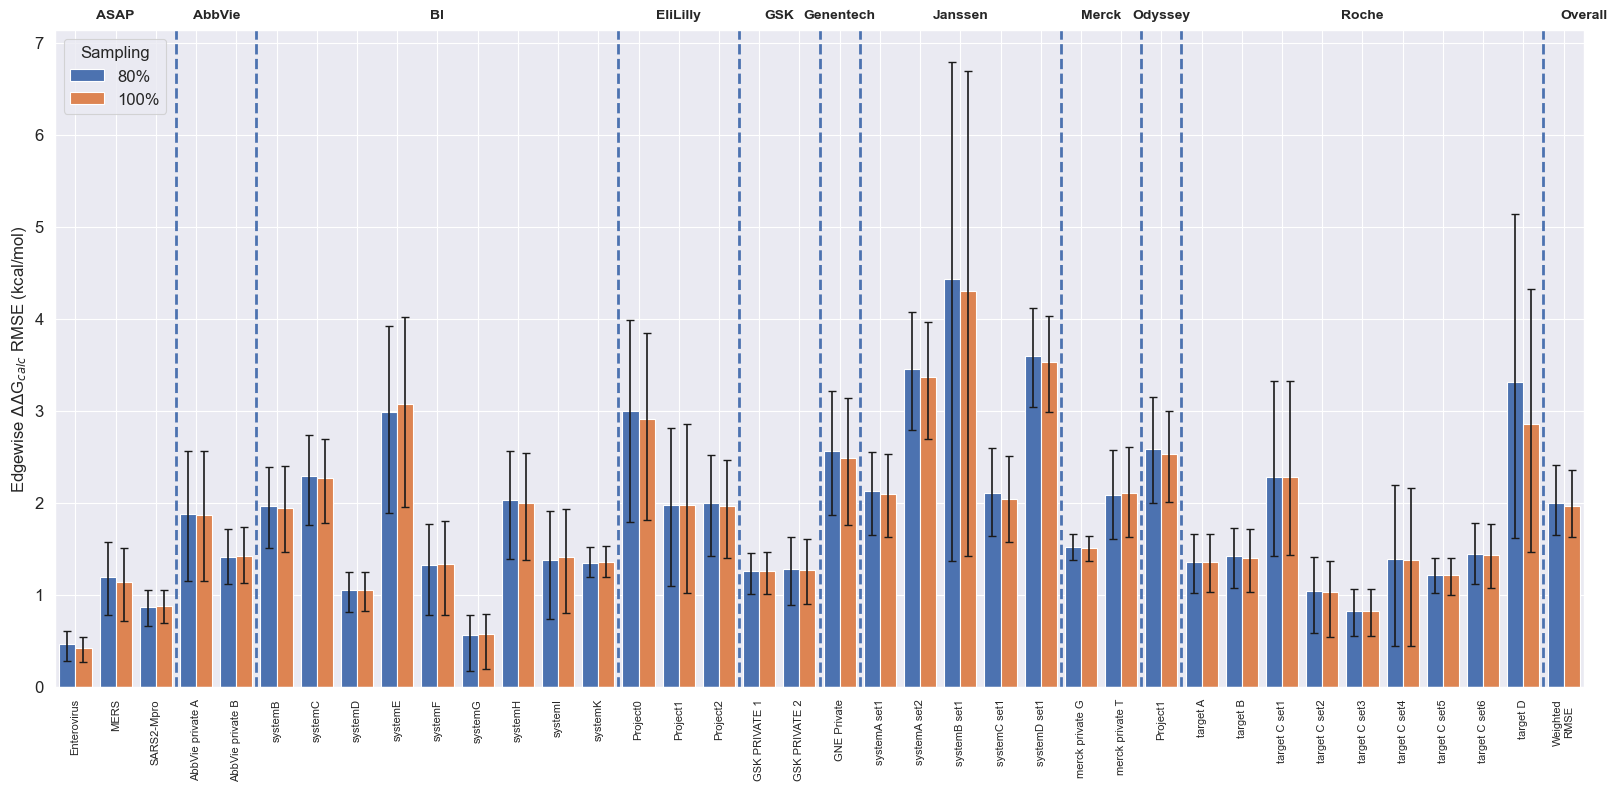

In [120]:
# plot the edgewise RMSE for 80% and 100% sampling
x = np.arange(len(edgewise_rmse_df_private))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.4

# Plot bars with error bars
rmse_err_80 = [edgewise_rmse_df_private['RMSE 80%'] - edgewise_rmse_df_private['RMSE 80% CI low'], edgewise_rmse_df_private['RMSE 80% CI high'] - edgewise_rmse_df_private['RMSE 80%']]
rmse_err_100 = [edgewise_rmse_df_private['RMSE 100%'] - edgewise_rmse_df_private['RMSE 100% CI low'], edgewise_rmse_df_private['RMSE 100% CI high'] - edgewise_rmse_df_private['RMSE 100%']]
# "OpenFE": "#009384", "FEP+": "#d9c4b1"
ax.bar(x - bar_width/2, edgewise_rmse_df_private['RMSE 80%'], yerr=rmse_err_80, width=bar_width, label='80%', capsize=3)
ax.bar(x + bar_width/2, edgewise_rmse_df_private['RMSE 100%'], yerr=rmse_err_100, width=bar_width, label='100%', capsize=3)

# Set labels and ticks
ax.set_xticks(x)
names = edgewise_rmse_df_private['system name'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=8)
ax.set_ylabel(r"Edgewise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontdict={"fontsize": 12})
# ax.set_title("Per-System RMSE and MUE with 95% Confidence Intervals")
ax.legend()

# Add colored background for classes
unique_classes = edgewise_rmse_df_private['system group'].unique()
# remove overall from the unique classes and add it to the end
unique_classes = [cls for cls in unique_classes if cls != "Overall"]
unique_classes.append("Overall")
class_bounds = edgewise_rmse_df_private.groupby('system group').size().cumsum().to_dict()
# # move overall to the end
class_bounds["Overall"] = len(edgewise_rmse_df_private) + 1

# change the roche end limit
class_bounds["Roche"] -= 1 # Adjust to match the last index of the class
print(class_bounds)
class_start = 0

colors = sns.color_palette("colorblind", len(unique_classes))
class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls]
    # add dashed lines for the span but not the fill
    if cls != "ASAP":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
#     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=10, weight='bold')
    class_start = end

plt.tight_layout()
plt.legend(title="Sampling", fontsize=12, title_fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.5, len(edgewise_rmse_df_private) - 0.5)
# plt.show()
plt.savefig("per_system_edgewise_rmse_sampling_private.png", dpi=300, bbox_inches='tight')